# NVIDIA Share Analysis

# 1) Importing modules 

In [9]:
import logging
import os
import time
import pickle
import io
import pandas as pd
import numpy as np
import yfinance as yf
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import pytz
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.impute import SimpleImputer
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.stats import norm
from scipy import optimize
from matplotlib.ticker import ScalarFormatter
from fredapi import Fred

# 2) Data Collection and Preparation

### 2.1) Python Script for Data Collection

In [10]:
# Set up logging
logging.basicConfig(filename='data_collection.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Configuration
CACHE_DIR = './cache'
MAX_RETRIES = 3
FRED_API_KEY = '612d0528496c7166790a6dae5040dec3' 

def get_cached_data(ticker, start_date, end_date):
    cache_file = os.path.join(CACHE_DIR, f"{ticker}_{start_date.date()}_{end_date.date()}.pkl")
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            data = pickle.load(f)
        if data.index[-1].date() >= end_date.date() - timedelta(days=1):
            logging.info(f"Using cached data for {ticker}")
            return data
    return None

def cache_data(ticker, data, start_date, end_date):
    if not os.path.exists(CACHE_DIR):
        os.makedirs(CACHE_DIR)
    cache_file = os.path.join(CACHE_DIR, f"{ticker}_{start_date.date()}_{end_date.date()}.pkl")
    with open(cache_file, 'wb') as f:
        pickle.dump(data, f)
    logging.info(f"Cached data for {ticker}")

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def get_stock_data(ticker, start_date, end_date, max_retries=MAX_RETRIES):
    cached_data = get_cached_data(ticker, start_date, end_date)
    if cached_data is not None:
        return cached_data

    for attempt in range(max_retries):
        try:
            stock_data = yf.download(ticker, start=start_date, end=end_date)
            if stock_data.empty:
                raise ValueError(f"No data available for {ticker}")
            
            close_column = 'Close' if 'Close' in stock_data.columns else 'Adj Close' if 'Adj Close' in stock_data.columns else None
            if close_column is None:
                raise ValueError(f"Neither 'Close' nor 'Adj Close' column found for {ticker}")
            
            stock_data['Daily_Return'] = stock_data[close_column].pct_change()
            stock_data['Log_Return'] = np.log(stock_data[close_column] / stock_data[close_column].shift(1))
            stock_data['Volatility'] = stock_data['Log_Return'].rolling(window=252).std() * np.sqrt(252)
            stock_data['SMA_50'] = stock_data[close_column].rolling(window=50).mean()
            stock_data['SMA_200'] = stock_data[close_column].rolling(window=200).mean()
            stock_data['RSI'] = calculate_rsi(stock_data[close_column])

            cache_data(ticker, stock_data, start_date, end_date)
            return stock_data
        except Exception as e:
            if attempt < max_retries - 1:
                logging.warning(f"Attempt {attempt + 1} failed for {ticker}: {str(e)}. Retrying...")
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                logging.error(f"Error fetching data for {ticker} after {max_retries} attempts: {str(e)}")
                return None

def get_stock_data_fallback(ticker, start_date, end_date):
    try:
        url = f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}"
        params = {
            "period1": int(start_date.timestamp()),
            "period2": int(end_date.timestamp()),
            "interval": "1d"
        }
        headers = {"User-Agent": "Mozilla/5.0"}
        response = requests.get(url, params=params, headers=headers)
        data = response.json()
        
        if 'chart' in data and 'result' in data['chart'] and data['chart']['result']:
            result = data['chart']['result'][0]
            timestamps = pd.to_datetime(result['timestamp'], unit='s')
            close_prices = result['indicators']['quote'][0]['close']
            df = pd.DataFrame({'Close': close_prices}, index=timestamps)
            return df
        else:
            logging.error(f"No data available for {ticker} using fallback method")
            return None
    except Exception as e:
        logging.error(f"Error fetching data for {ticker} using fallback method: {str(e)}")
        return None

def get_competitor_data(competitors, start_date, end_date):
    competitor_data = {}
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_competitor = {executor.submit(get_stock_data, comp, start_date, end_date): comp for comp in competitors}
        for future in as_completed(future_to_competitor):
            competitor = future_to_competitor[future]
            try:
                data = future.result()
                if data is not None:
                    competitor_data[competitor] = data
                else:
                    logging.warning(f"Attempting fallback method for {competitor}")
                    fallback_data = get_stock_data_fallback(competitor, start_date, end_date)
                    if fallback_data is not None:
                        competitor_data[competitor] = fallback_data
                        logging.info(f"Successfully retrieved data for {competitor} using fallback method")
                    else:
                        logging.error(f"Failed to retrieve data for {competitor} using both primary and fallback methods")
            except Exception as e:
                logging.error(f"Error fetching data for competitor {competitor}: {str(e)}")
    return competitor_data

def get_financial_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        income_stmt = stock.financials
        balance_sheet = stock.balance_sheet
        cash_flow = stock.cashflow
        return pd.concat([income_stmt, balance_sheet, cash_flow], axis=0)
    except Exception as e:
        logging.error(f"Error fetching financial data for {ticker}: {str(e)}")
        return None

def get_options_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        options = stock.option_chain()
        return options
    except Exception as e:
        logging.error(f"Error fetching options data for {ticker}: {str(e)}")
        return None

def get_macroeconomic_data(start_date, end_date):
    try:
        fred = Fred(api_key=FRED_API_KEY)
        indicators = {
            'GDP': 'GDP',
            'Unemployment_Rate': 'UNRATE',
            'Inflation_Rate': 'T10YIE',
            'Interest_Rate': 'FEDFUNDS'
        }

        macro_data = {}
        for indicator, series_id in indicators.items():
            try:
                data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
                if not data.empty:
                    macro_data[indicator] = data
                else:
                    logging.warning(f"No data available for {indicator} (Series ID: {series_id})")
            except Exception as e:
                logging.error(f"Error fetching data for {indicator} (Series ID: {series_id}): {str(e)}")

        if macro_data:
            return pd.DataFrame(macro_data)
        else:
            logging.error("No macroeconomic data could be fetched")
            return None
    except Exception as e:
        logging.error(f"Error in get_macroeconomic_data: {str(e)}")
        return None

def save_data(data, filename):
    if data is not None and not data.empty:
        data.to_csv(f'data/{filename}')
        logging.info(f"Successfully saved {filename}")
    else:
        logging.warning(f"No data to save for {filename}")

def main():
    logging.info("Starting data collection process")

    # Set date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=25*365)  # 25 years of data

    # Fetch and save data with error handling
    data_collection_tasks = [
        ("NVDA", get_stock_data, "nvidia_stock_data.csv"),
        ("^GSPC", get_stock_data, "sp500_data.csv"),
        ("^IXIC", get_stock_data, "nasdaq_data.csv"),
        ("^SOX", get_stock_data, "sox_data.csv"),
    ]

    for ticker, fetch_function, filename in data_collection_tasks:
        try:
            data = fetch_function(ticker, start_date, end_date)
            save_data(data, filename)
        except Exception as e:
            logging.error(f"Error processing {ticker}: {str(e)}")

    # Fetch competitor data
    competitors = ['AMD', 'INTC', 'TSM', 'MU']
    competitor_data = get_competitor_data(competitors, start_date, end_date)
    for competitor, data in competitor_data.items():
        save_data(data, f"{competitor}_stock_data.csv")

    # Get and save NVIDIA financial and options data
    try:
        nvidia_financials = get_financial_data("NVDA")
        save_data(nvidia_financials, "nvidia_financials.csv")

        nvidia_options = get_options_data("NVDA")
        if nvidia_options is not None:
            save_data(nvidia_options.calls, "nvidia_options_calls.csv")
            save_data(nvidia_options.puts, "nvidia_options_puts.csv")
            logging.info("Successfully saved NVIDIA options data")
        else:
            logging.warning("No NVIDIA options data to save")
    except Exception as e:
        logging.error(f"Error processing NVIDIA financial or options data: {str(e)}")

    # Get and save macroeconomic data
    try:
        macro_data = get_macroeconomic_data(start_date, end_date)
        save_data(macro_data, "macroeconomic_data.csv")
    except Exception as e:
        logging.error(f"Error processing macroeconomic data: {str(e)}")

    logging.info("Data collection and preparation complete")

if __name__ == "__main__":
    main()



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



### 2.2) Data Validation and Cleaning

In [11]:
# Set up logging
logging.basicConfig(filename='nvidia_stock_analysis.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def clean_stock_data(df):
    if df is None or df.empty:
        logging.error("Empty or None DataFrame provided to clean_stock_data")
        return None

    close_column = 'Close' if 'Close' in df.columns else 'Adj Close' if 'Adj Close' in df.columns else None
    if close_column is None:
        logging.error("Neither 'Close' nor 'Adj Close' column found in stock data.")
        return df

    # Remove rows with missing values
    df_cleaned = df.dropna(subset=[close_column])
    
    # Check for and remove outliers (e.g., using Z-score)
    z_scores = np.abs((df_cleaned[close_column] - df_cleaned[close_column].mean()) / df_cleaned[close_column].std())
    df_cleaned = df_cleaned[z_scores < 3]
    
    return df_cleaned

def clean_financial_data(df):
    if df is None or df.empty:
        logging.error("Empty or None DataFrame provided to clean_financial_data")
        return None

    # Replace '--' with NaN
    df = df.replace('--', np.nan)
    
    # Convert to numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return df_imputed

def download_stock_data(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        return data
    except Exception as e:
        logging.error(f"Error downloading data for {ticker}: {str(e)}")
        return None

def clean_all_data():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=25*365)  # 25 years of data

    # Clean NVIDIA stock data
    nvidia_data = download_stock_data("NVDA", start_date, end_date)
    if nvidia_data is not None:
        nvidia_data_cleaned = clean_stock_data(nvidia_data)
        if nvidia_data_cleaned is not None:
            nvidia_data_cleaned.to_csv('data/nvidia_stock_data_cleaned.csv')
            logging.info("Successfully cleaned and saved NVIDIA stock data")
        else:
            logging.error("Failed to clean NVIDIA stock data")
    else:
        logging.error("Failed to download NVIDIA stock data")

    # Clean financial data
    if os.path.exists('data/nvidia_financials.csv'):
        nvidia_financials = pd.read_csv('data/nvidia_financials.csv', index_col=0)
        nvidia_financials_cleaned = clean_financial_data(nvidia_financials)
        if nvidia_financials_cleaned is not None:
            nvidia_financials_cleaned.to_csv('data/nvidia_financials_cleaned.csv')
            logging.info("Successfully cleaned and saved NVIDIA financial data")
        else:
            logging.error("Failed to clean NVIDIA financial data")
    else:
        logging.error("NVIDIA financial data file not found")

    # Clean competitor data
    competitors = ['AMD', 'INTC', 'TSM', 'MU']
    for competitor in competitors:
        comp_data = download_stock_data(competitor, start_date, end_date)
        if comp_data is not None:
            comp_data_cleaned = clean_stock_data(comp_data)
            if comp_data_cleaned is not None:
                comp_data_cleaned.to_csv(f'data/{competitor}_stock_data_cleaned.csv')
                logging.info(f"Successfully cleaned and saved {competitor} stock data")
            else:
                logging.error(f"Failed to clean {competitor} stock data")
        else:
            logging.error(f"Failed to download {competitor} stock data")

    # Clean macroeconomic data
    if os.path.exists('data/macroeconomic_data.csv'):
        try:
            # First, try to read the CSV file without specifying an index column
            macro_data = pd.read_csv('data/macroeconomic_data.csv')
            
            # Check if 'Date' column exists
            if 'Date' in macro_data.columns:
                # If 'Date' column exists, set it as index and parse dates
                macro_data['Date'] = pd.to_datetime(macro_data['Date'])
                macro_data.set_index('Date', inplace=True)
            else:
                # If 'Date' column doesn't exist, use the first column as index
                macro_data.set_index(macro_data.columns[0], inplace=True)
                macro_data.index = pd.to_datetime(macro_data.index)
            
            macro_data_cleaned = clean_financial_data(macro_data)
            if macro_data_cleaned is not None:
                macro_data_cleaned.to_csv('data/macroeconomic_data_cleaned.csv')
                logging.info("Successfully cleaned and saved macroeconomic data")
            else:
                logging.error("Failed to clean macroeconomic data")
        except Exception as e:
            logging.error(f"Error processing macroeconomic data: {str(e)}")
    else:
        logging.error("Macroeconomic data file not found")

    logging.info("Data cleaning process complete")

if __name__ == "__main__":
    clean_all_data()

# Read the financial data
df = pd.read_csv('data/nvidia_financials_cleaned.csv', index_col=0)

# Transpose the dataframe
df_transposed = df.transpose()

# Reset the index to make the date a column
df_transposed.reset_index(inplace=True)
df_transposed.rename(columns={'index': 'Date'}, inplace=True)

# Convert the Date column to datetime
df_transposed['Date'] = pd.to_datetime(df_transposed['Date'])

# Sort the dataframe by date
df_transposed.sort_values('Date', inplace=True)

# Replace '22000000.0' with NaN as it seems to be a placeholder value
df_transposed.replace(22000000.0, np.nan, inplace=True)

# Convert all numeric columns to float
numeric_columns = df_transposed.columns.drop('Date')
df_transposed[numeric_columns] = df_transposed[numeric_columns].astype(float)

# Save the pivoted data to a new CSV file
df_transposed.to_csv('data/nvidia_financials_pivoted.csv', index=False)

class DataCleaner:
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def remove_duplicates(self):
        self.data = self.data.drop_duplicates()
        logging.info("Duplicates removed")

    def handle_missing_values(self):
        self.data = self.data.fillna(method='ffill')
        logging.info("Missing values handled")

    def remove_outliers(self, columns, threshold=3):
        for col in columns:
            z_scores = np.abs((self.data[col] - self.data[col].mean()) / self.data[col].std())
            self.data = self.data[(z_scores < threshold)]
        logging.info("Outliers removed")

    def validate_data_types(self):
        expected_types = {
            'Open': 'float64',
            'High': 'float64',
            'Low': 'float64',
            'Close': 'float64',
            'Volume': 'int64',
            'EPS': 'float64',
            # Add more columns and their expected types
        }
        for col, expected_type in expected_types.items():
            if col in self.data.columns and self.data[col].dtype != expected_type:
                self.data[col] = self.data[col].astype(expected_type)
        logging.info("Data types validated and corrected")

    def clean_data(self):
        self.remove_duplicates()
        self.handle_missing_values()
        self.remove_outliers(['Open', 'High', 'Low', 'Close', 'Volume'])
        self.validate_data_types()
        return self.data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# 3)Exploratory Data Analysis (EDA) Overview

In [12]:
def analyze_dataframe(df, df_name):
    print(f"\n--- Analysis for {df_name} ---\n")
    
    print("Head of the DataFrame:")
    print(df.head())
    print("\nDataFrame Description:")
    print(df.describe())
    print("\nDataFrame Info:")
    df.info()
    print("\nNull Values Count:")
    print(df.isnull().sum())
    print("\nUnique Values in Object Columns:")
    print(df.select_dtypes(include='object').nunique())

# Function to read CSV files and perform analysis
def read_and_analyze_csv(file_path, df_name):
    try:
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        analyze_dataframe(df, df_name)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error analyzing {df_name}: {str(e)}")

# List of DataFrames to analyze
dataframes_to_analyze = [
    ('data/nvidia_stock_data_cleaned.csv', 'NVIDIA Stock Data'),
    ('data/nvidia_financials_cleaned.csv', 'NVIDIA Financials'),
    ('data/AMD_stock_data_cleaned.csv', 'AMD Stock Data'),
    ('data/INTC_stock_data_cleaned.csv', 'Intel Stock Data'),
    ('data/TSM_stock_data_cleaned.csv', 'TSMC Stock Data'),
    ('data/MU_stock_data_cleaned.csv', 'Micron Stock Data'),
    ('data/macroeconomic_data_cleaned.csv', 'Macroeconomic Data'),
]

# Analyze all DataFrames
for file_path, df_name in dataframes_to_analyze:
    read_and_analyze_csv(file_path, df_name)


def __init__(self, data: pd.DataFrame):
        self.data = data

def summary_statistics(self):
        return self.data.describe()

def correlation_analysis(self):
        return self.data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

def plot_time_series(self, column: str):
        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index, self.data[column])
        plt.title(f'{column} Over Time')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.show()
        plt.savefig(f'images/time_series.png')
        plt.close()

def plot_distribution(self, column: str):
        plt.figure(figsize=(10, 6))
        sns.histplot(self.data[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.show()
        plt.savefig(f'images/distribution.png')
        plt.close()

def run_eda(self):
        print(self.summary_statistics())
        print(self.correlation_analysis())
        self.plot_time_series('Close')
        self.plot_distribution('Volume')
        logging.info("Exploratory Data Analysis completed")


--- Analysis for NVIDIA Stock Data ---

Head of the DataFrame:
                Open      High       Low     Close  Adj Close      Volume
Date                                                                     
1999-10-06  0.044661  0.052083  0.044271  0.049870   0.045738  1508736000
1999-10-07  0.051953  0.051953  0.046354  0.046615   0.042753   487296000
1999-10-08  0.046615  0.050391  0.044792  0.048958   0.044902   398928000
1999-10-11  0.049349  0.049479  0.046354  0.047656   0.043708   544464000
1999-10-12  0.047917  0.048438  0.046875  0.047005   0.043111   322992000

DataFrame Description:
              Open         High          Low        Close    Adj Close  \
count  6119.000000  6119.000000  6119.000000  6119.000000  6119.000000   
mean      4.519982     4.601887     4.435995     4.523237     4.495405   
std       9.447254     9.610275     9.278762     9.455133     9.455477   
min       0.041146     0.042448     0.039714     0.040495     0.037140   
25%       0.287500     0

# 4)Data Analysis and Model Development

### 4.1) Comparing NVIDIA's performance with market indices

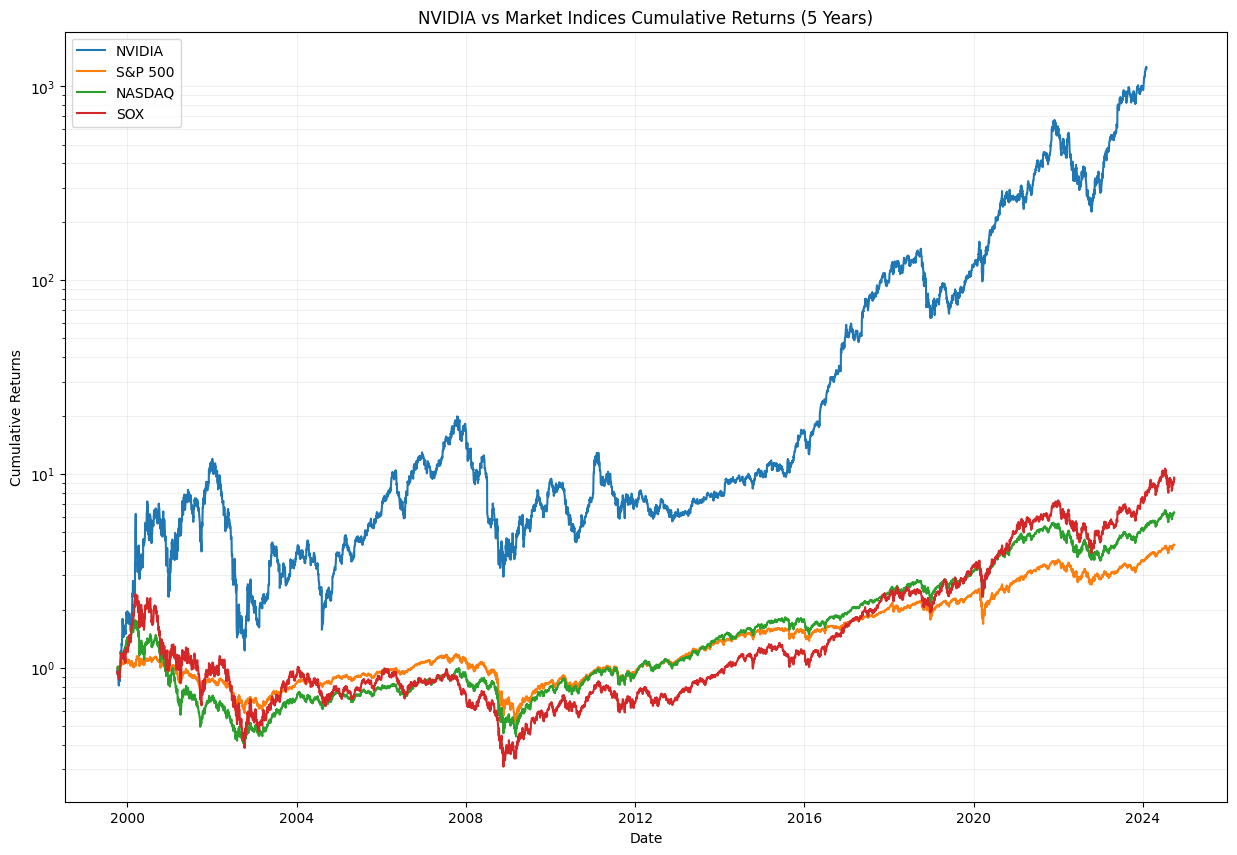

In [13]:
def compare_performance_with_indices():
    logging.info("Comparing NVIDIA's performance with market indices")

    # Load data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)
    sp500_data = pd.read_csv('data/sp500_data.csv', index_col='Date', parse_dates=True)
    nasdaq_data = pd.read_csv('data/nasdaq_data.csv', index_col='Date', parse_dates=True)
    sox_data = pd.read_csv('data/sox_data.csv', index_col='Date', parse_dates=True)

    # Calculate returns
    nvidia_returns = nvidia_data['Close'].pct_change()
    sp500_returns = sp500_data['Close'].pct_change()
    nasdaq_returns = nasdaq_data['Close'].pct_change()
    sox_returns = sox_data['Close'].pct_change()

    # Combine returns
    combined_returns = pd.concat([nvidia_returns, sp500_returns, nasdaq_returns, sox_returns], axis=1)
    combined_returns.columns = ['NVIDIA', 'S&P 500', 'NASDAQ', 'SOX']

    # Calculate cumulative returns
    cumulative_returns = (1 + combined_returns).cumprod()

    # Plot cumulative returns
    plt.figure(figsize=(15, 10))
    for column in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

    plt.title("NVIDIA vs Market Indices Cumulative Returns (5 Years)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Returns")
    plt.legend()
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.savefig('images/nvidia_vs_indices_performance.png')
    plt.show()
    plt.close()

    logging.info("Performance comparison complete")

if __name__ == "__main__":
    compare_performance_with_indices()

### 4.2) Analyzing key financial metrics

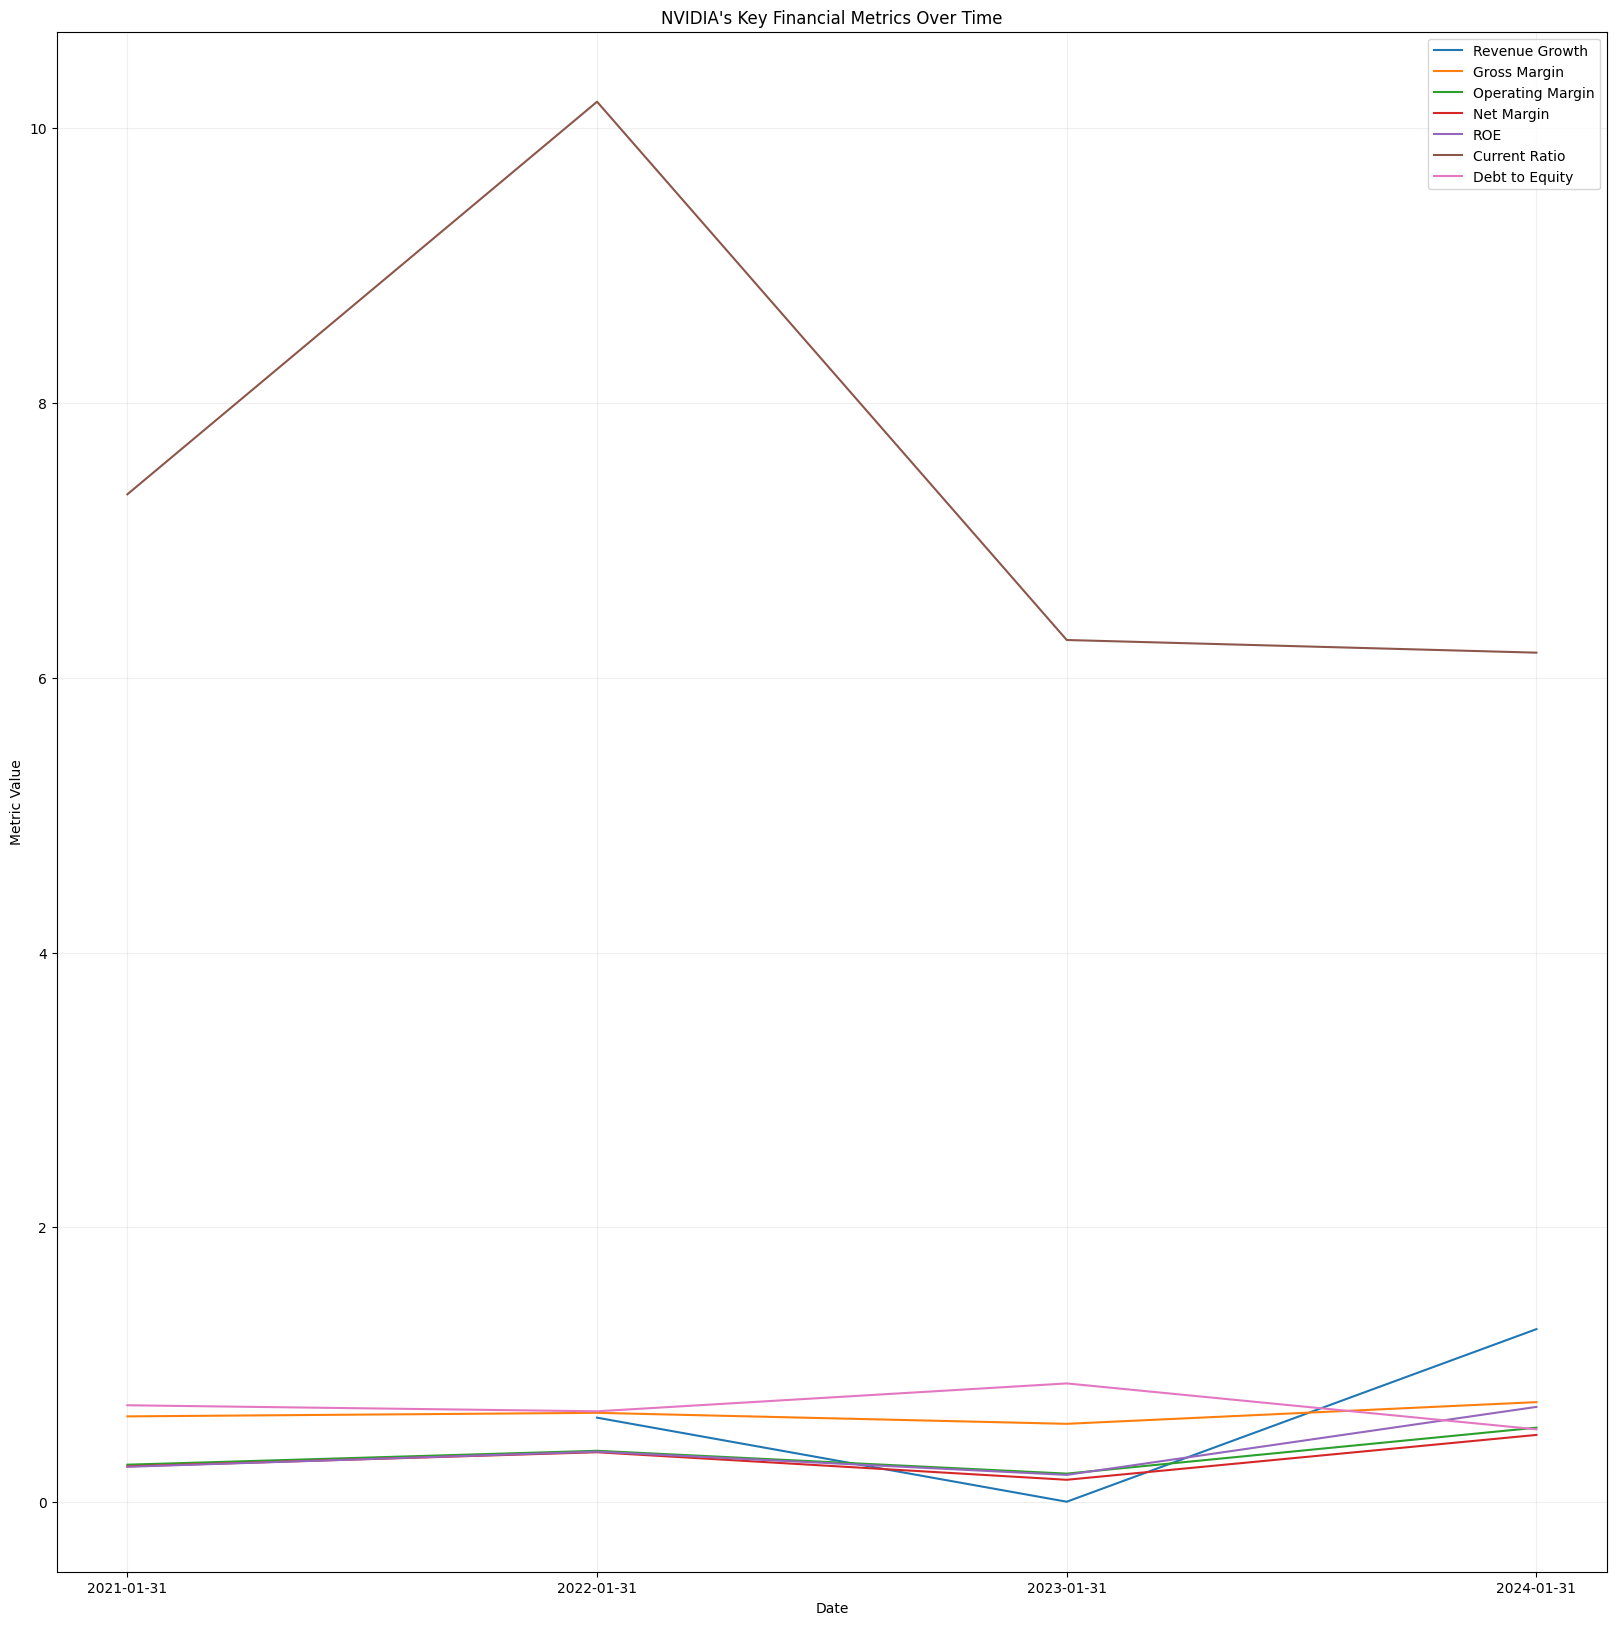

In [14]:
def analyze_financial_metrics():
    logging.info("Analyzing NVIDIA's key financial metrics")

    # Load financial data
    financials = pd.read_csv('data/nvidia_financials_pivoted.csv', index_col=0)

    # Calculate key metrics
    metrics = pd.DataFrame({
        'Revenue Growth': financials['Total Revenue'].pct_change(),
        'Gross Margin': financials['Gross Profit'] / financials['Total Revenue'],
        'Operating Margin': financials['Operating Income'] / financials['Total Revenue'],
        'Net Margin': financials['Net Income'] / financials['Total Revenue'],
        'ROE': financials['Net Income'] / financials['Stockholders Equity'],
        'Current Ratio': financials['Total Assets'] / financials['Current Liabilities'],
        'Debt to Equity': financials['Total Liabilities Net Minority Interest'] / financials['Stockholders Equity']
    })

    # Plot metrics over time
    plt.figure(figsize=(20, 20))
    for column in metrics.columns:
        plt.plot(metrics.index, metrics[column], label=column)

    plt.title("NVIDIA's Key Financial Metrics Over Time")
    plt.xlabel("Date")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.savefig('images/nvidia_financial_metrics.png')
    plt.show()
    plt.close()

    logging.info("Financial metrics analysis complete")

if __name__ == "__main__":
    analyze_financial_metrics()


### 4.3)Competitor Analysis

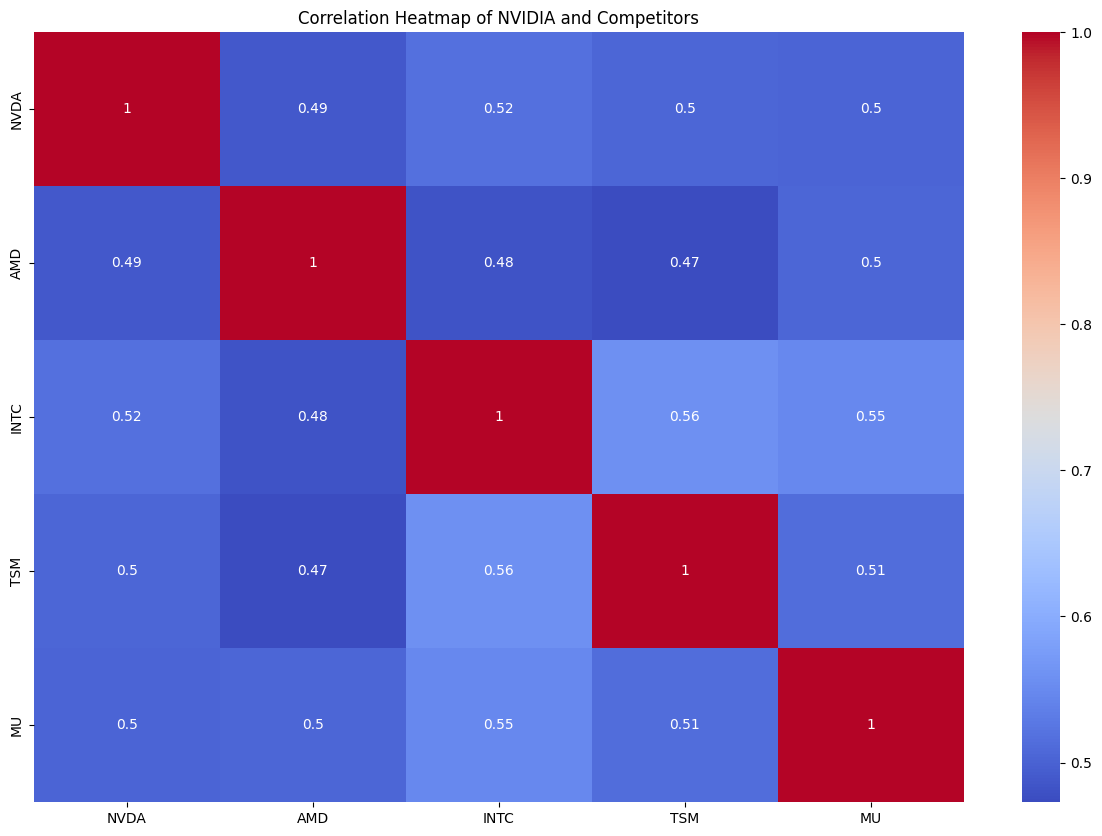

In [15]:
# Data for the companies and their market capitalization
# Data for the companies and their market capitalization
data = [
    ["Company", "Market Cap (in billion USD)", "Market share %"],
    ["NVIDIA", 2977],
    ["AMD", 266],
    ["Intel", 118],
    ["MU", 119],
    ["TSMC", 489]
]

# Calculate total market capitalization
total_market_cap = sum([row[1] for row in data[1:]])

# Calculate and append market share percentage for each company
for row in data[1:]:
    market_share = (row[1] / total_market_cap) * 100  # Calculate market share
    row.append(round(market_share, 2))  # Add market share percentage

# Define the file path
file_path = "data/market_caps.csv"

def calculate_beta(stock_returns, market_returns):
    # Align the stock returns and market returns by their date index
    stock_returns, market_returns = stock_returns.align(market_returns, join='inner')
    
    # Calculate covariance and variance
    covariance = np.cov(stock_returns, market_returns)[0][1]
    market_variance = np.var(market_returns)
    
    return covariance / market_variance

# Write the data to a CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(data)

file_path


def run_competitor_analysis():
    logging.info("Starting competitor analysis")

    # Load NVIDIA and competitor data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)
    competitors = ['AMD', 'INTC', 'TSM', 'MU']
    competitor_data = {comp: pd.read_csv(f'data/{comp}_stock_data_cleaned.csv', index_col='Date', parse_dates=True) for comp in competitors}

    # Load market data (S&P 500)
    market_data = pd.read_csv('data/sp500_data.csv', index_col='Date', parse_dates=True)

    # Calculate returns
    nvidia_returns = nvidia_data['Close'].pct_change().dropna()
    market_returns = market_data['Close'].pct_change().dropna()
    competitor_returns = {comp: data['Close'].pct_change().dropna() for comp, data in competitor_data.items()}

    # Calculate beta for NVIDIA and competitors
    nvidia_beta = calculate_beta(nvidia_returns, market_returns)
    competitor_betas = {comp: calculate_beta(returns, market_returns) for comp, returns in competitor_returns.items()}

    # Calculate correlation matrix
    all_returns = pd.concat([nvidia_returns] + list(competitor_returns.values()), axis=1).dropna()
    all_returns.columns = ['NVDA'] + competitors
    correlation_matrix = all_returns.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap of NVIDIA and Competitors')
    plt.show()
    plt.savefig('images/nvidia_competitor_correlation.png')
    plt.close()

    # Compare performance
    performance_comparison = pd.DataFrame({
        'Company': ['NVDA'] + competitors,
        'Beta': [nvidia_beta] + [competitor_betas[comp] for comp in competitors],
        'Annual_Return': [nvidia_returns.mean() * 252] + [returns.mean() * 252 for returns in competitor_returns.values()],
        'Annual_Volatility': [nvidia_returns.std() * np.sqrt(252)] + [returns.std() * np.sqrt(252) for returns in competitor_returns.values()]
    })

    performance_comparison.to_csv('data/competitor_performance_comparison.csv', index=False)

    logging.info("Competitor analysis complete")

if __name__ == "__main__":
    run_competitor_analysis()


### 4.4) Technical Indicator Analysis

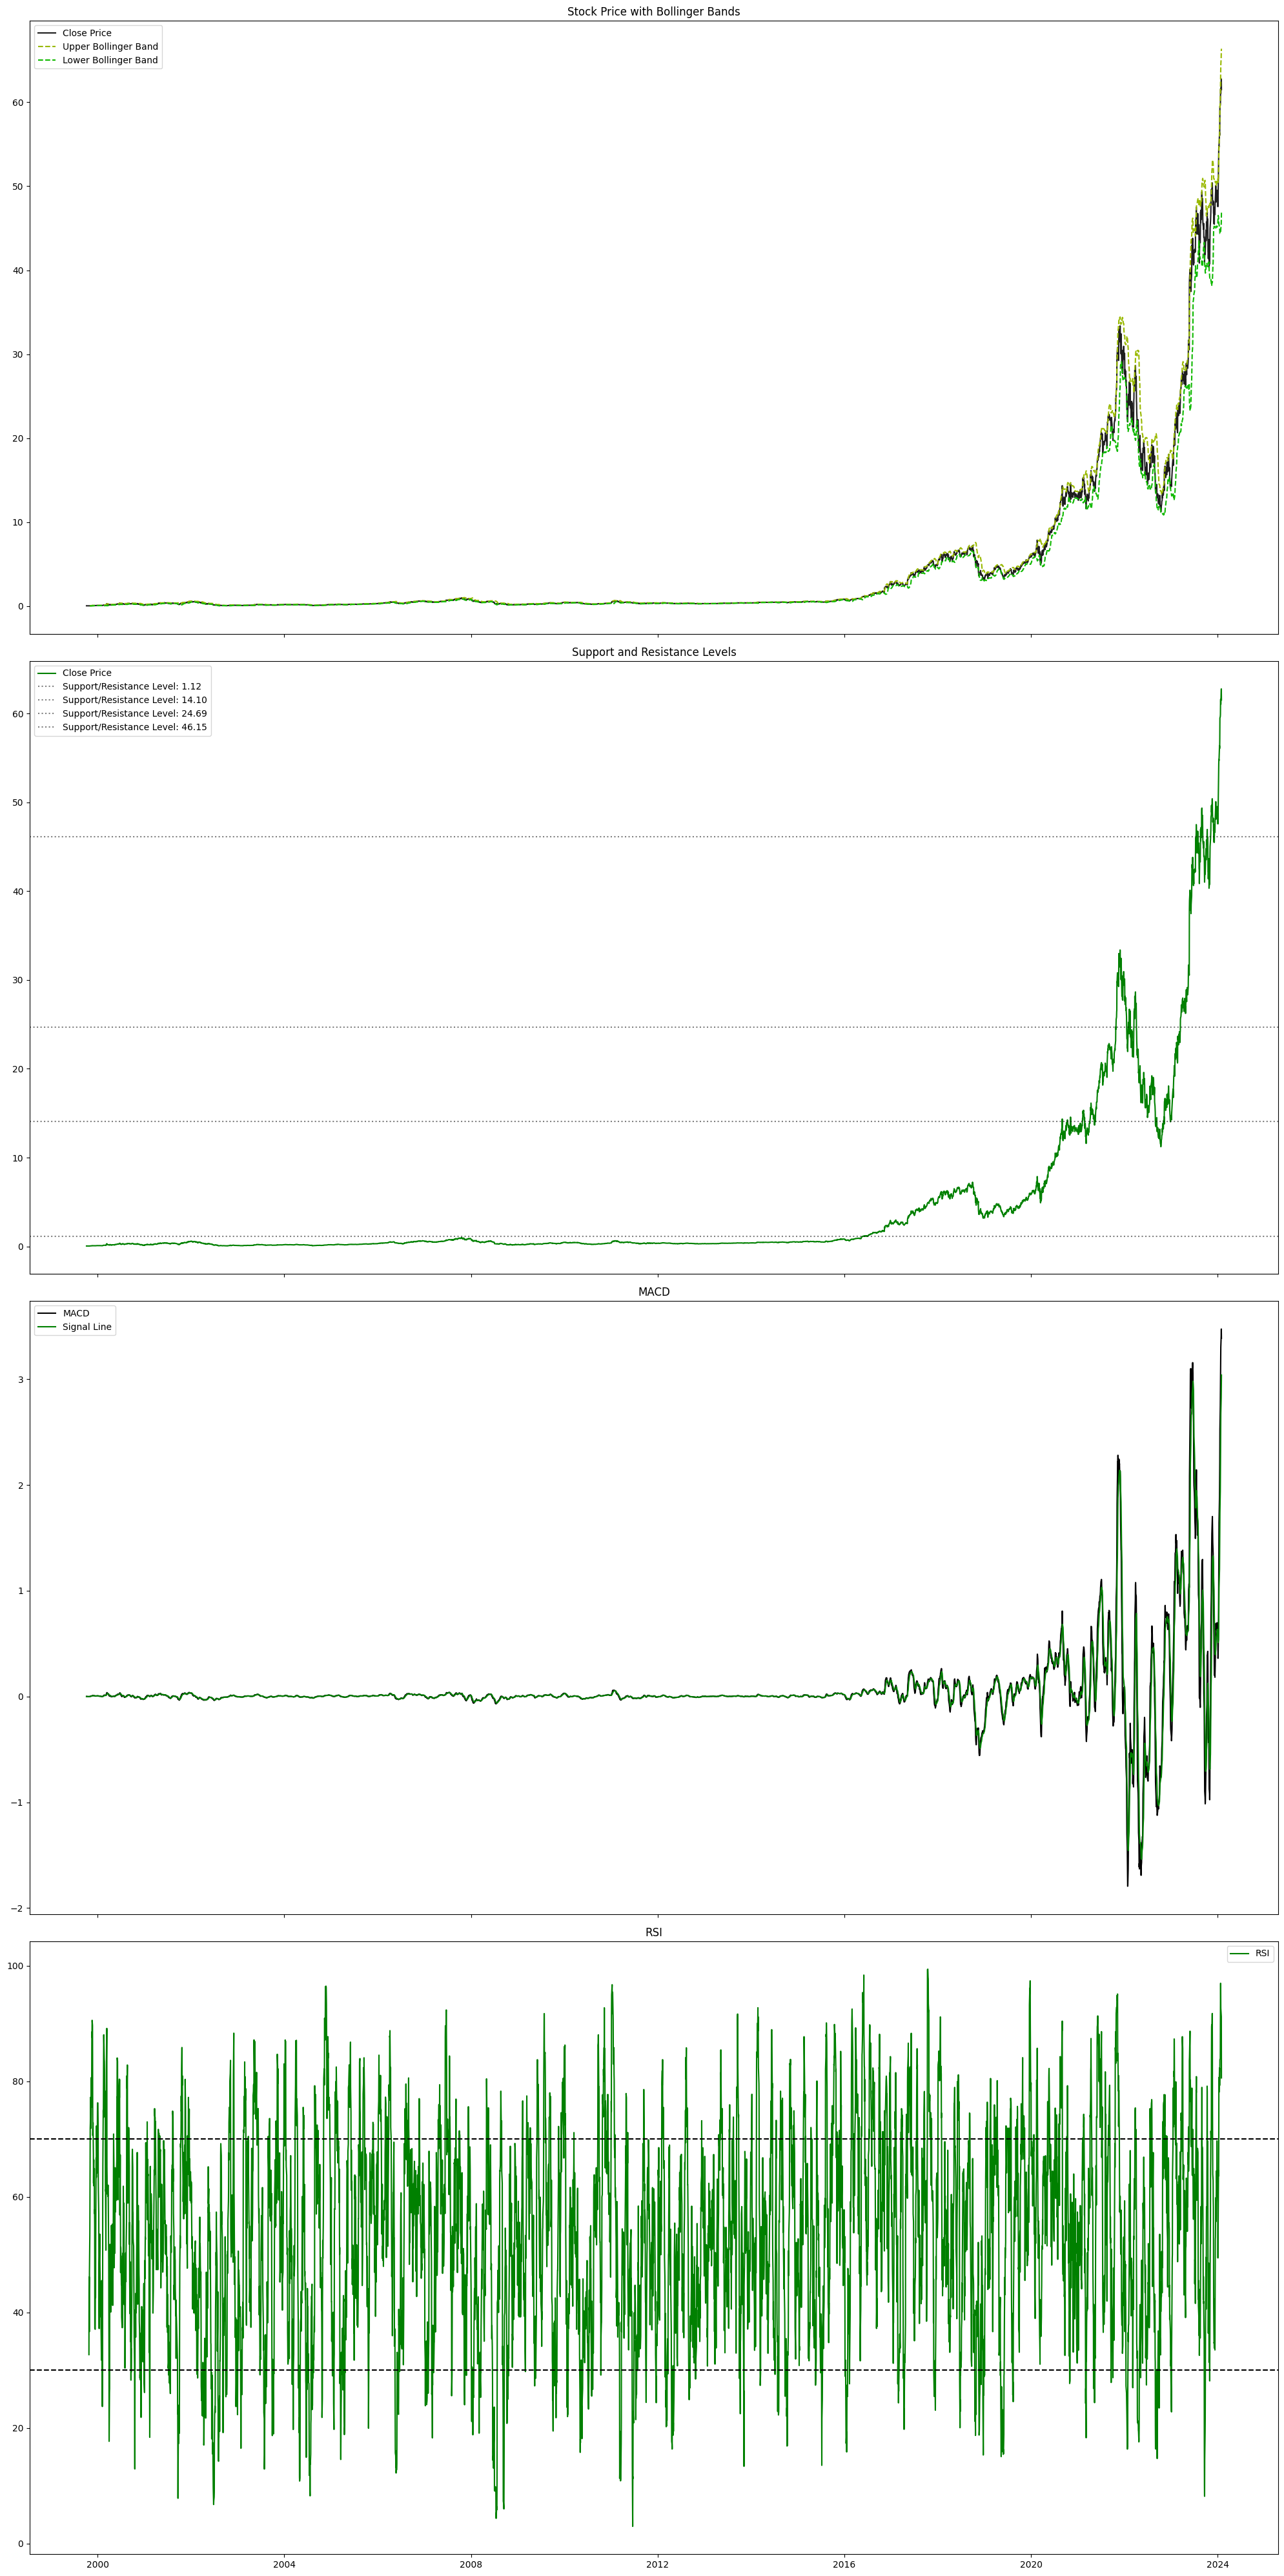

In [16]:
# Set up logging
logging.basicConfig(filename='technical_analysis.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

nvidia_stock_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)

# Price Volatility: Standard deviation of returns
def calculate_volatility(data, window=30):
    returns = data['Close'].pct_change()
    volatility = returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
    return volatility

nvidia_stock_data['Volatility'] = calculate_volatility(nvidia_stock_data)

def analyze_volume_trends(data, window=20):
    data['Avg_Volume'] = data['Volume'].rolling(window=window).mean()
    data['Volume_Spike'] = data['Volume'] > data['Avg_Volume'] * 2  # Flag volumes 2x above average
    return data

nvidia_stock_data = analyze_volume_trends(nvidia_stock_data)

# MACD Calculation
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# Linear Bollinger Bands
def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# RSI Calculation
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Support and Resistance Levels (using K-Means)
def identify_support_resistance(data, window=20):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(scaled_data)
    levels = scaler.inverse_transform(kmeans.cluster_centers_)
    return sorted(levels.flatten())

# Plot all technical indicators
def plot_technical_indicators(data, macd, signal, upper_bb, lower_bb, rsi, support_resistance):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 40), sharex=True)

    # Price and Linear Bollinger Bands
    ax1.plot(data.index, data['Close'], label='Close Price', color='#1E1E1E')
    ax1.plot(data.index, upper_bb, label='Upper Bollinger Band', linestyle='--', color='#99B900')
    ax1.plot(data.index, lower_bb, label='Lower Bollinger Band', linestyle='--', color='#10B900')
    
    ax1.set_title('Stock Price with Bollinger Bands')
    ax1.legend()

    # Support and Resistance Levels
    ax2.plot(data.index, data['Close'], label='Close Price', color='g')
    for level in support_resistance:
        ax2.axhline(y=level, color='#000000', linestyle=':', alpha=0.5, label=f'Support/Resistance Level: {level:.2f}')
    ax2.set_title('Support and Resistance Levels')
    ax2.legend()

    # MACD
    ax3.plot(data.index, macd, label='MACD', color='black')
    ax3.plot(data.index, signal, label='Signal Line', color='green')
    ax3.set_title('MACD')
    ax3.legend()

    # RSI
    ax4.plot(data.index, rsi, label='RSI', color='green')
    ax4.axhline(y=70, color='#000000', linestyle='--')
    ax4.axhline(y=30, color='#000000', linestyle='--')
    ax4.set_title('RSI')
    ax4.legend()

    plt.tight_layout()
    plt.savefig('images/nvidia_technical_indicators_with_support_resistance.png')
    plt.show()


# Main function to run the analysis
def run_technical_analysis():
    logging.info("Starting technical indicator analysis")

    # Load stock data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)

    # Calculate technical indicators
    macd, signal = calculate_macd(nvidia_data['Close'])
    upper_bb, lower_bb = calculate_bollinger_bands(nvidia_data['Close'])
    rsi = calculate_rsi(nvidia_data['Close'])
    support_resistance = identify_support_resistance(nvidia_data['Close'])

    # Plot technical indicators
    plot_technical_indicators(nvidia_data, macd, signal, upper_bb, lower_bb, rsi, support_resistance)

    # Add indicators to the dataframe
    nvidia_data['MACD'] = macd
    nvidia_data['Signal_Line'] = signal
    nvidia_data['Upper_BB'] = upper_bb
    nvidia_data['Lower_BB'] = lower_bb
    nvidia_data['RSI'] = rsi

    # Save the data with technical indicators
    nvidia_data.to_csv('data/nvidia_stock_data_with_indicators.csv')

    logging.info("Technical indicator analysis complete")

if __name__ == "__main__":
    run_technical_analysis()


### 4.5) Options Analysis

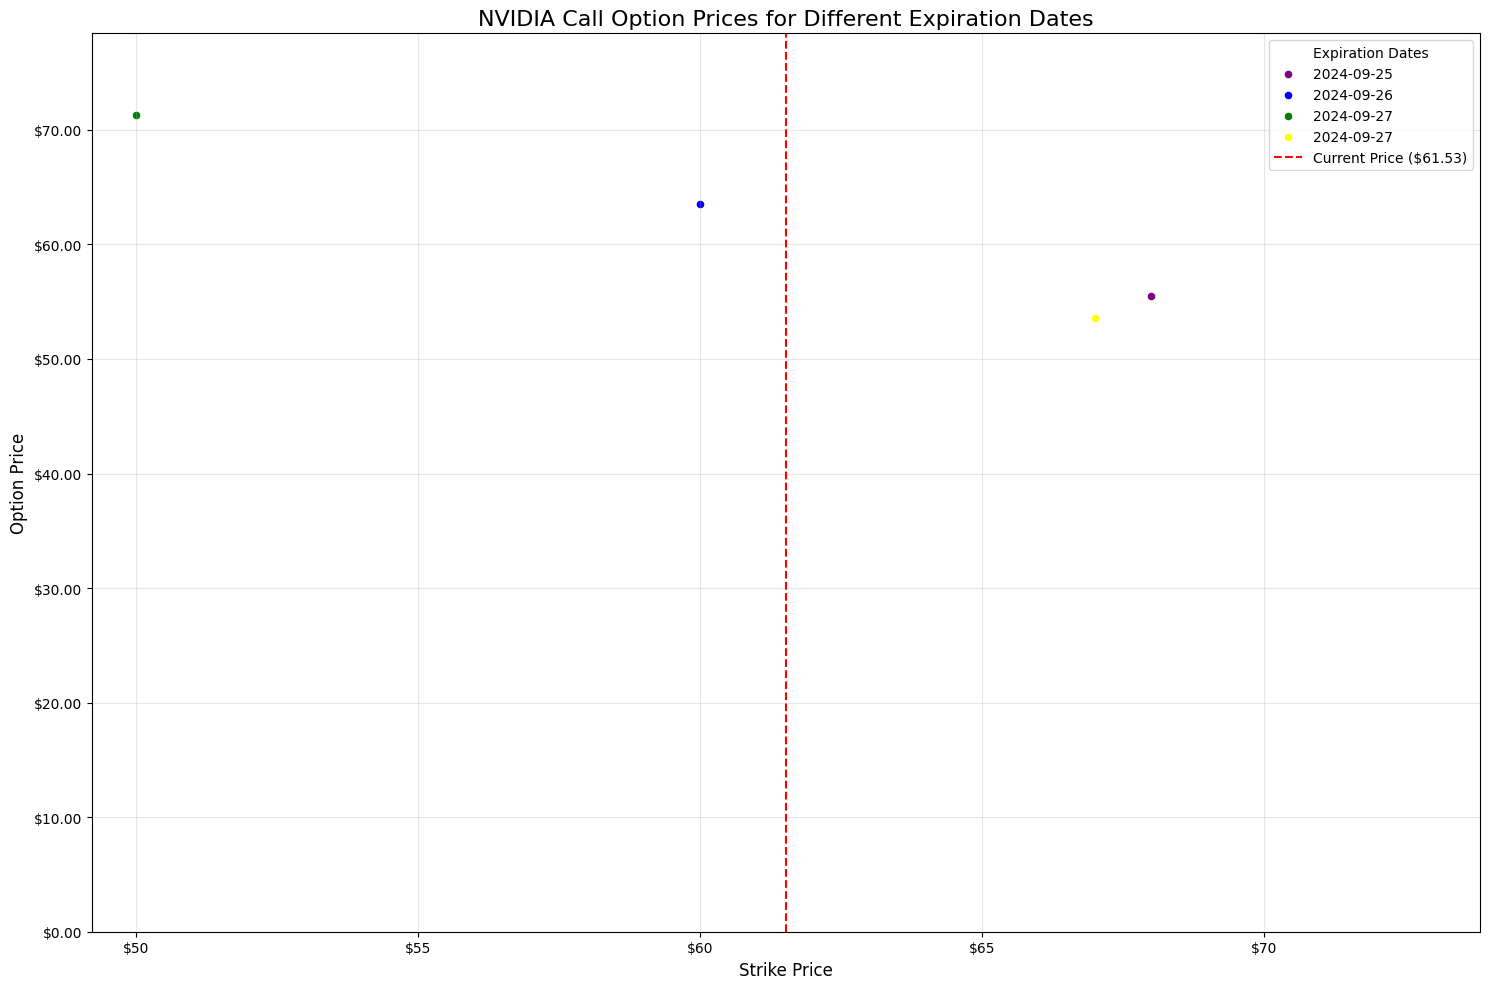

In [17]:
def run_refined_options_analysis():
    logging.info("Starting refined options analysis")

    # Load NVIDIA options data and stock price data
    calls = pd.read_csv('data/nvidia_options_calls.csv')
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv')
    
    # Get the latest NVIDIA stock price
    current_price = nvidia_data['Close'].iloc[-1]
    
    # Convert expiration dates to datetime, ensuring they are timezone-naive
    calls['lastTradeDate'] = pd.to_datetime(calls['lastTradeDate']).dt.tz_localize(None)
    
    # Calculate days to expiration
    today = pd.to_datetime('today').normalize()
    calls['daysToExpiration'] = (calls['lastTradeDate'] - today).dt.days
    
    # Filter valid options (positive price and volume) and handle data cleaning
    calls = calls[(calls['lastPrice'] > 0) & (calls['volume'] > 0)]
    
    # Dynamically adjust the strike price range based on market conditions
    # Assume a wider range for a highly volatile stock like NVIDIA (e.g., ±20%)
    lower_bound = current_price * 0.80
    upper_bound = current_price * 1.20
    calls = calls[(calls['strike'] >= lower_bound) & (calls['strike'] <= upper_bound)]
    
    # Remove potential duplicate expiration dates
    unique_expirations = calls['lastTradeDate'].drop_duplicates().sort_values()
    
    # Select a reasonable number of distinct expiration dates (e.g., the next 4 upcoming dates)
    selected_expirations = unique_expirations[:4]

    # Start plotting the refined data
    plt.figure(figsize=(15, 10))
    colors = ['purple', 'blue', 'green', 'yellow']  # Use distinct colors for different expirations
    
    # Plot call option prices for each expiration date
    for i, expiry in enumerate(selected_expirations):
        expiry_calls = calls[calls['lastTradeDate'] == expiry]
        if not expiry_calls.empty:
            plt.scatter(expiry_calls['strike'], expiry_calls['lastPrice'], 
                        label=expiry.strftime('%Y-%m-%d'),
                        color=colors[i % len(colors)], 
                        s=20)
    
    # Add chart titles and labels
    plt.title('NVIDIA Call Option Prices for Different Expiration Dates', fontsize=16)
    plt.xlabel('Strike Price', fontsize=12)
    plt.ylabel('Option Price', fontsize=12)
    
    # Highlight the current stock price with a red dashed line
    plt.axvline(x=current_price, color='red', linestyle='--', label=f'Current Price (${current_price:.2f})')
    
    # Set axis limits to a more dynamic range, based on the filtered data
    plt.xlim(lower_bound, upper_bound)
    plt.ylim(0, max(calls['lastPrice']) * 1.1)  # Extend Y-axis to capture higher prices

    # Add a grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.3)

    # Format the x-axis and y-axis to show currency values
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:,.2f}'))

    # Add legend to show the different expiration dates
    plt.legend(loc='upper right', title="Expiration Dates")
    
    # Tighten the layout and display the plot
    plt.tight_layout()
    plt.show()
    
    # Save the figure as an image
    plt.savefig('images/nvidia_call_option_prices_refined.png', bbox_inches='tight', dpi=300)
    plt.close()

    logging.info("Refined options analysis complete")

# Run the refined analysis
if __name__ == "__main__":
    run_refined_options_analysis()


### 4.6) Sentiment Analysis

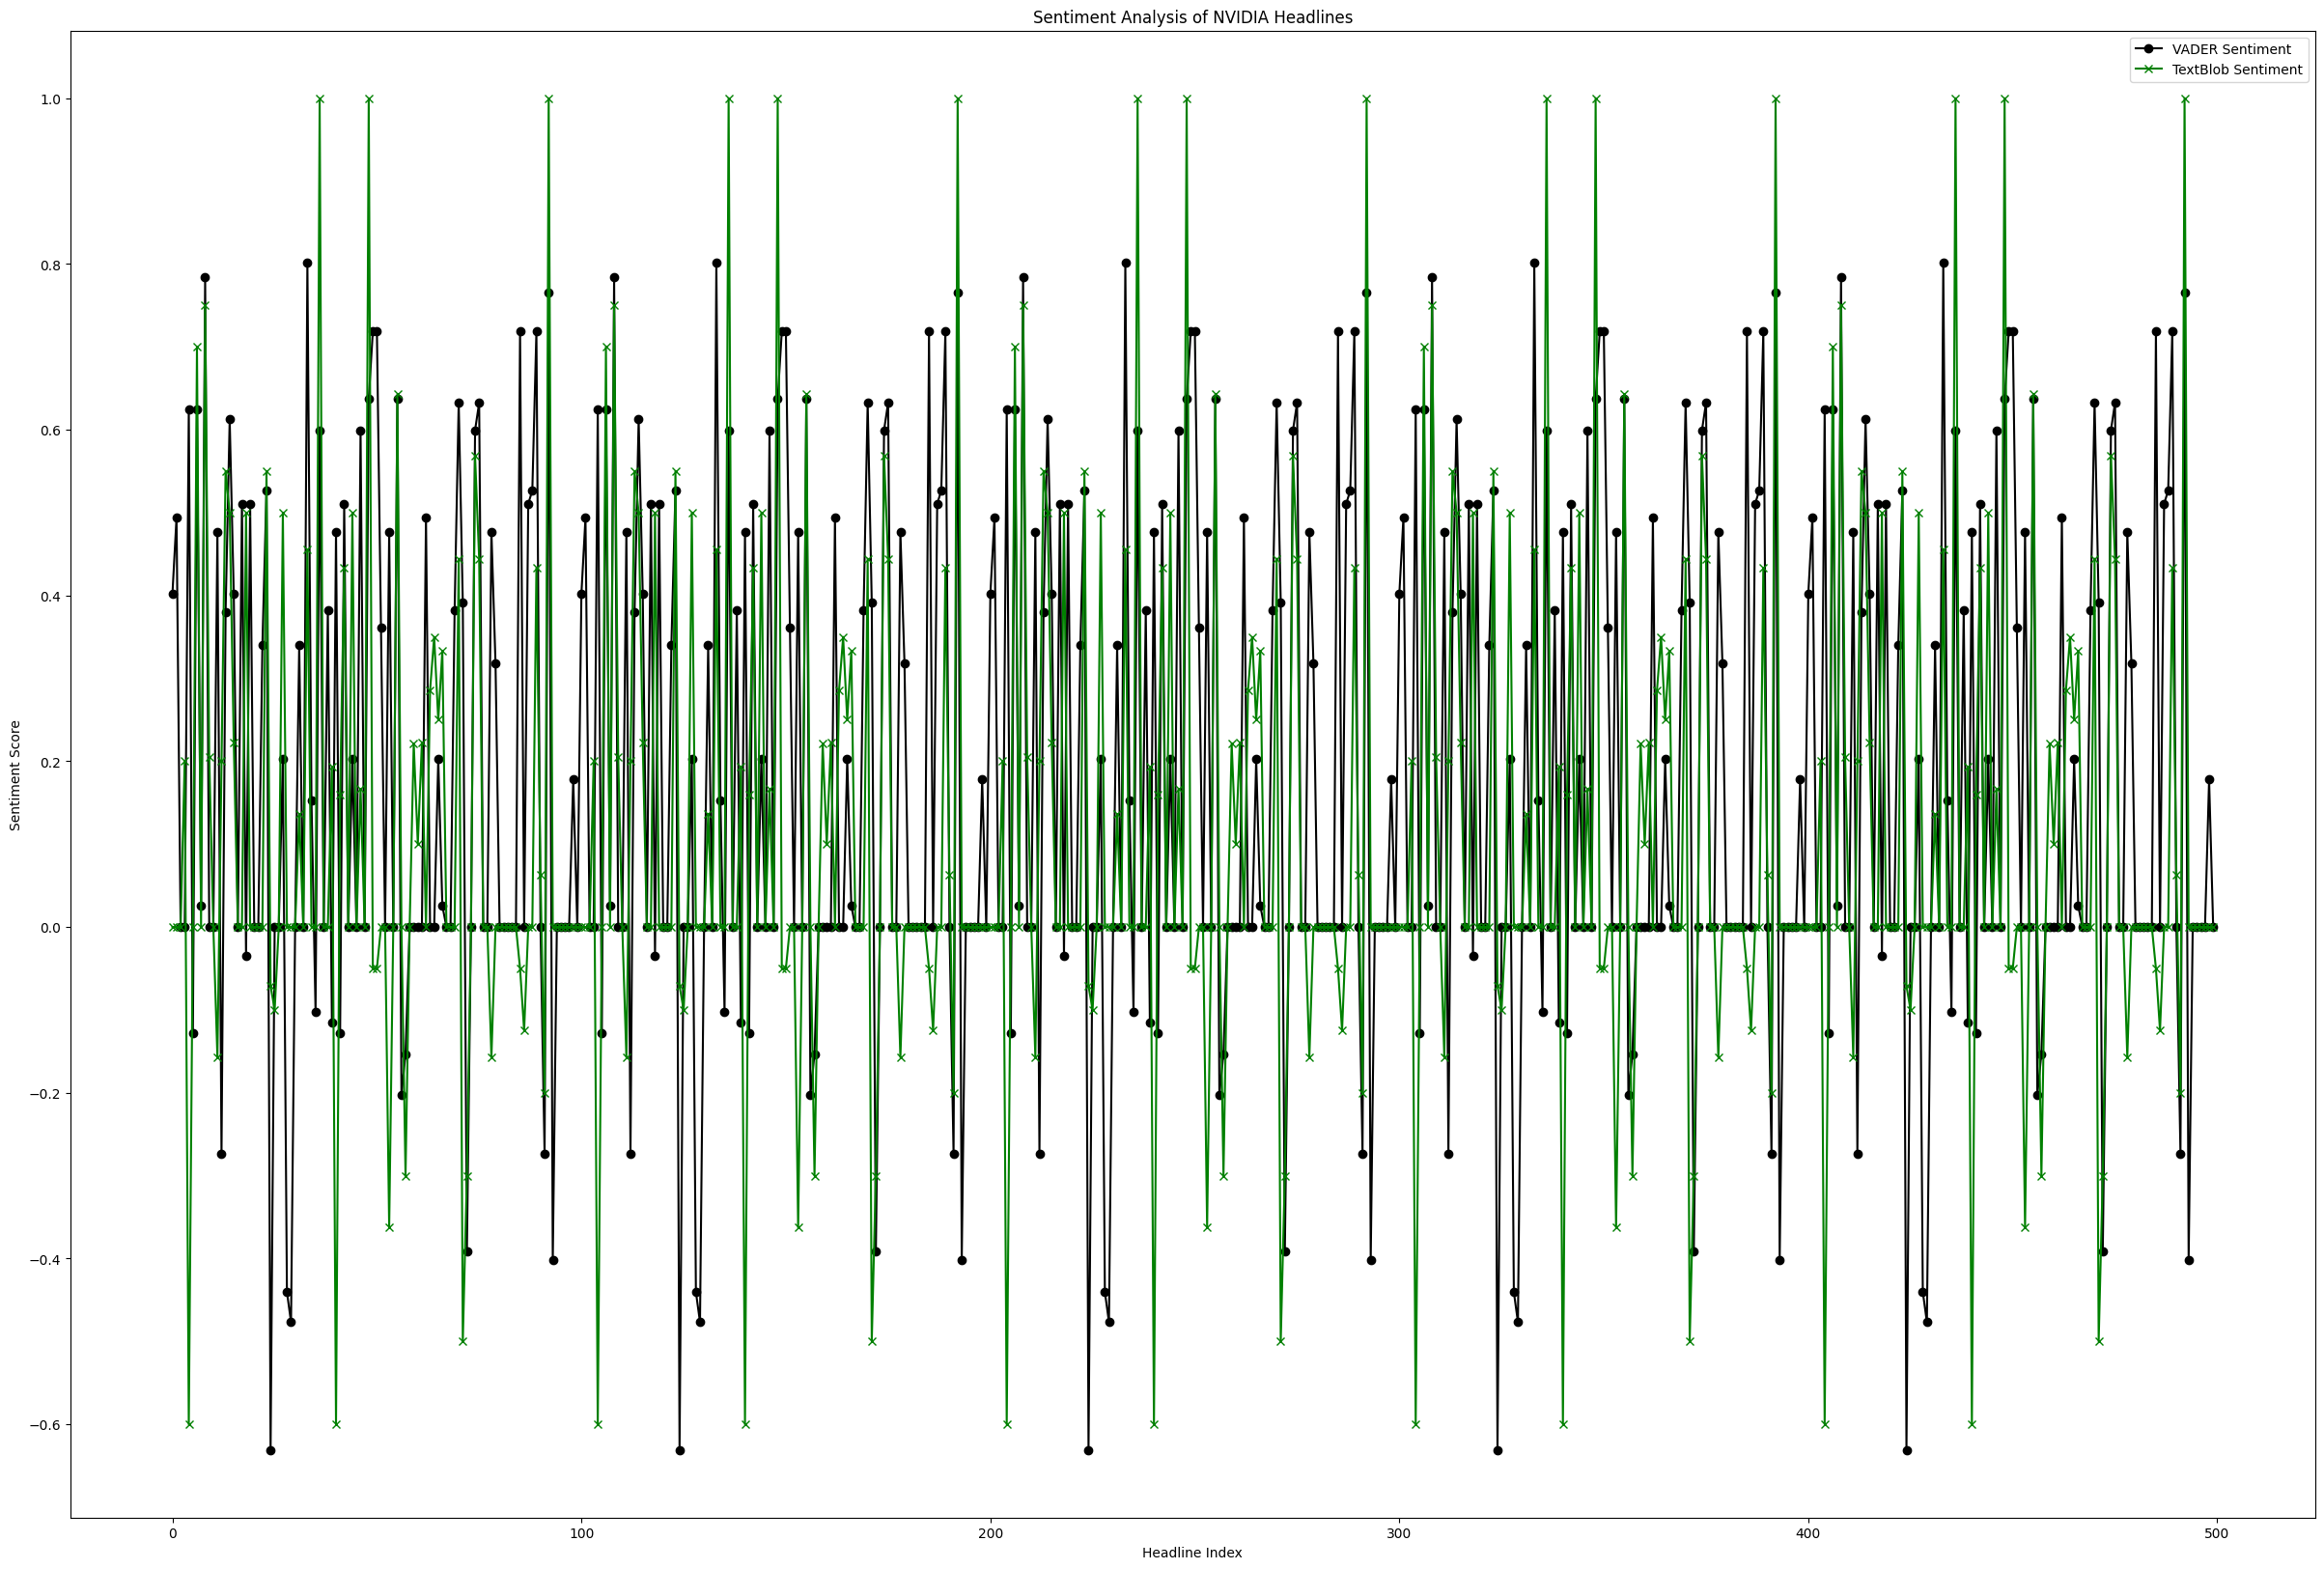

In [18]:
def get_news_headlines(ticker, num_pages=5):
    headlines = []
    for page in range(1, num_pages + 1):
        url = f"https://finviz.com/quote.ashx?t={ticker}&p=d&b=1"
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for a in soup.find_all('a', class_='tab-link-news'):
            headlines.append(a.text)
    return headlines

def analyze_sentiment_vader(text):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

def analyze_sentiment_textblob(text):
    return TextBlob(text).sentiment.polarity

def run_sentiment_analysis():
    logging.info("Starting sentiment analysis")

    # Get NVIDIA news headlines
    headlines = get_news_headlines("NVDA")

    # Analyze sentiment
    vader_sentiments = [analyze_sentiment_vader(headline) for headline in headlines]
    textblob_sentiments = [analyze_sentiment_textblob(headline) for headline in headlines]

    # Create a dataframe with the results
    sentiment_df = pd.DataFrame({
        'Headline': headlines,
        'VADER_Sentiment': vader_sentiments,
        'TextBlob_Sentiment': textblob_sentiments
    })

    # Calculate average sentiment
    avg_vader_sentiment = np.mean(vader_sentiments)
    avg_textblob_sentiment = np.mean(textblob_sentiments)

    logging.info(f"Average VADER sentiment: {avg_vader_sentiment}")
    logging.info(f"Average TextBlob sentiment: {avg_textblob_sentiment}")

    # Save sentiment data
    sentiment_df.to_csv('data/nvidia_sentiment_data.csv', index=False)

    # Plot sentiment scores
    plt.figure(figsize=(30, 20))
    plt.plot(vader_sentiments, label='VADER Sentiment', marker='o', color='black')  
    plt.plot(textblob_sentiments, label='TextBlob Sentiment', marker='x', color='green') 
    plt.title('Sentiment Analysis of NVIDIA Headlines')
    plt.title('Sentiment Analysis of NVIDIA Headlines')
    plt.xlabel('Headline Index')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.show()
    plt.savefig('images/nvidia_sentiment_analysis.png')
    plt.close()

    logging.info("Sentiment analysis complete")

if __name__ == "__main__":
    run_sentiment_analysis()

### 4.7)Analyzing impact of external factors

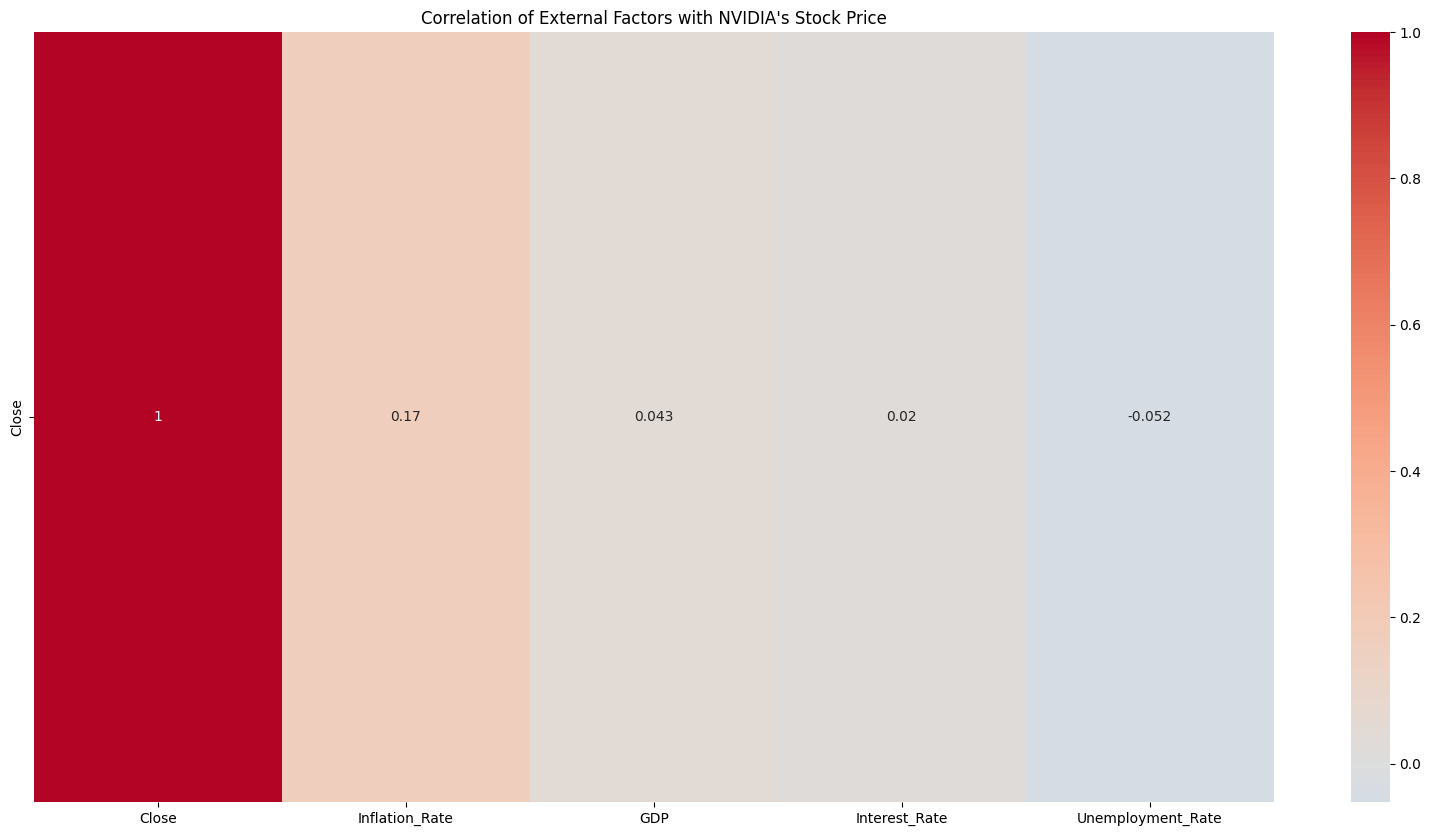

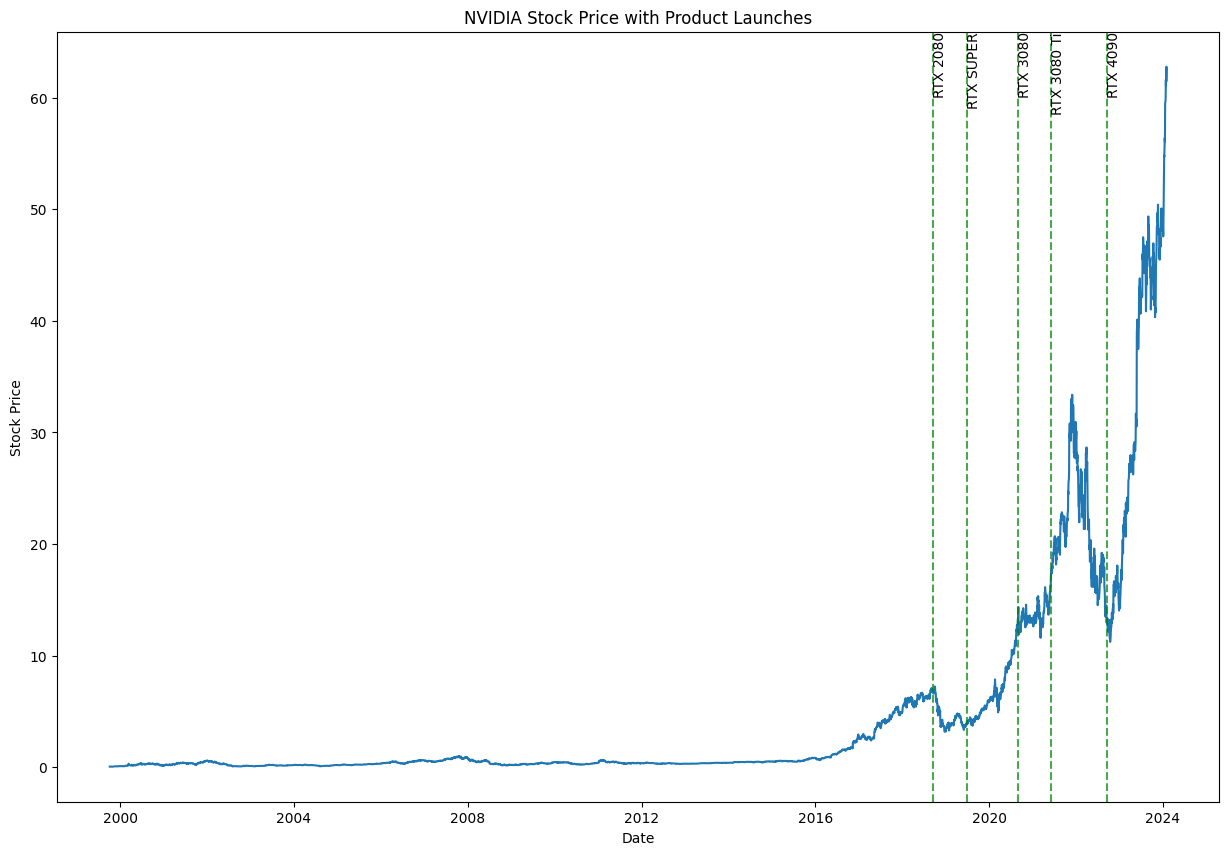

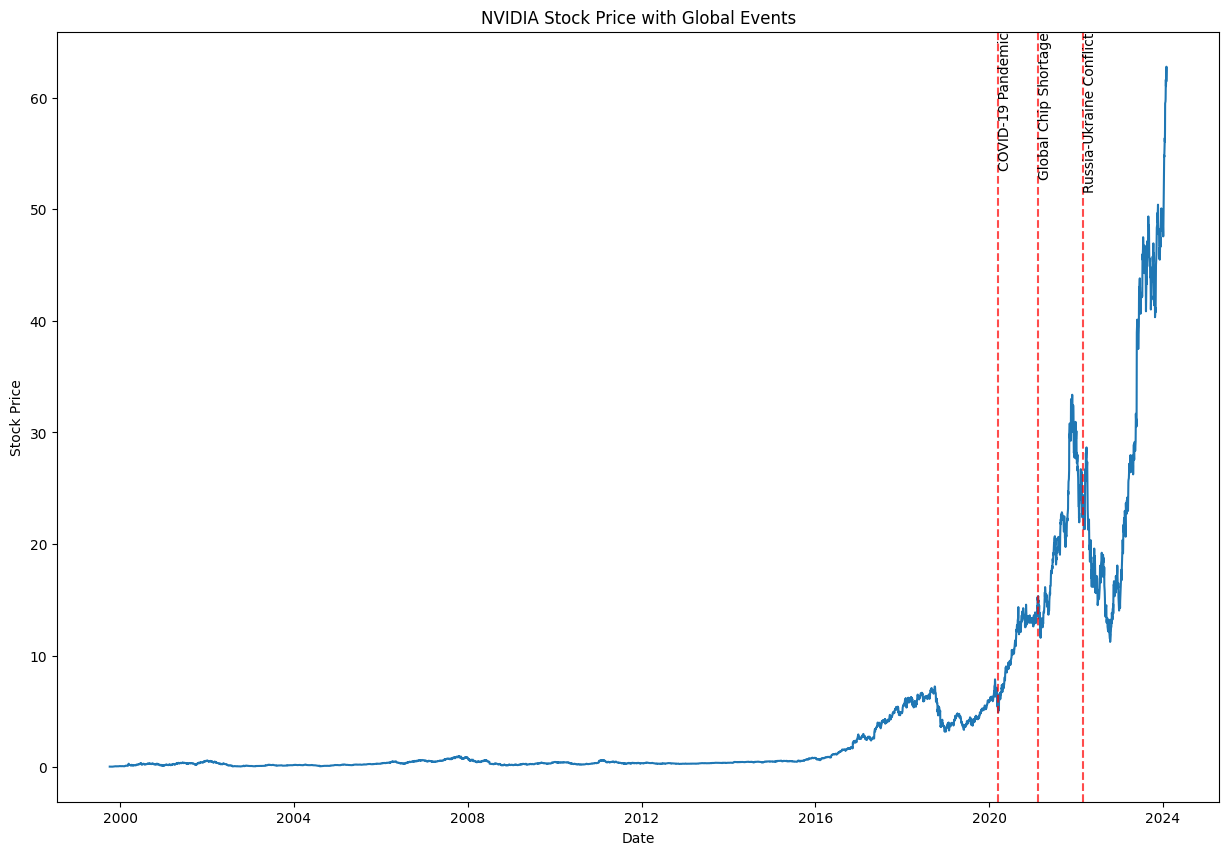

In [23]:
def analyze_external_factors():
    logging.info("Analyzing impact of external factors on NVIDIA's stock price")

    # Load data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)
    macro_data = pd.read_csv('data/macroeconomic_data_cleaned.csv', index_col='Date', parse_dates=True)

    # Add product launch dates (example dates, replace with actual dates)
    product_launches = pd.DataFrame({
        'Date': ['2018-09-20', '2019-07-02', '2020-09-01', '2021-06-01', '2022-09-20'],
        'Event': ['RTX 2080', 'RTX SUPER', 'RTX 3080', 'RTX 3080 Ti', 'RTX 4090']
    })
    product_launches['Date'] = pd.to_datetime(product_launches['Date'])

    # Add global events (example events, replace with actual significant events)
    global_events = pd.DataFrame({
        'Date': ['2020-03-11', '2021-02-12', '2022-02-24'],
        'Event': ['COVID-19 Pandemic', 'Global Chip Shortage', 'Russia-Ukraine Conflict']
    })
    global_events['Date'] = pd.to_datetime(global_events['Date'])

    # Combine data
    combined_data = pd.concat([nvidia_data['Close'], macro_data], axis=1)

    # Calculate correlations
    correlations = combined_data.corr()['Close'].sort_values(ascending=False)

    # Plot heatmap of correlations
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlations.to_frame().T, annot=True, cmap='coolwarm', center=0)
    plt.title("Correlation of External Factors with NVIDIA's Stock Price")
    plt.savefig('images/nvidia_external_factors_correlation.png')
    plt.show()
    plt.close()

    # Analyze impact of product launches
    plt.figure(figsize=(15, 10))
    plt.plot(nvidia_data.index, nvidia_data['Close'])
    for _, launch in product_launches.iterrows():
        plt.axvline(launch['Date'], color='g', linestyle='--', alpha=0.7)
        plt.text(launch['Date'], plt.ylim()[1], launch['Event'], rotation=90, verticalalignment='top')
    plt.title("NVIDIA Stock Price with Product Launches")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.savefig('images/nvidia_stock_product_launches.png')
    plt.show()
    plt.close()

    # Analyze impact of global events
    plt.figure(figsize=(15, 10))
    plt.plot(nvidia_data.index, nvidia_data['Close'])
    for _, event in global_events.iterrows():
        plt.axvline(event['Date'], color='r', linestyle='--', alpha=0.7)
        plt.text(event['Date'], plt.ylim()[1], event['Event'], rotation=90, verticalalignment='top')
    plt.title("NVIDIA Stock Price with Global Events")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.savefig('images/nvidia_stock_global_events.png')
    plt.show()
    plt.close()

    logging.info("Enhanced external factors analysis complete")

if __name__ == "__main__":
    analyze_external_factors()

### 4.8)Analyzing past stock splits:

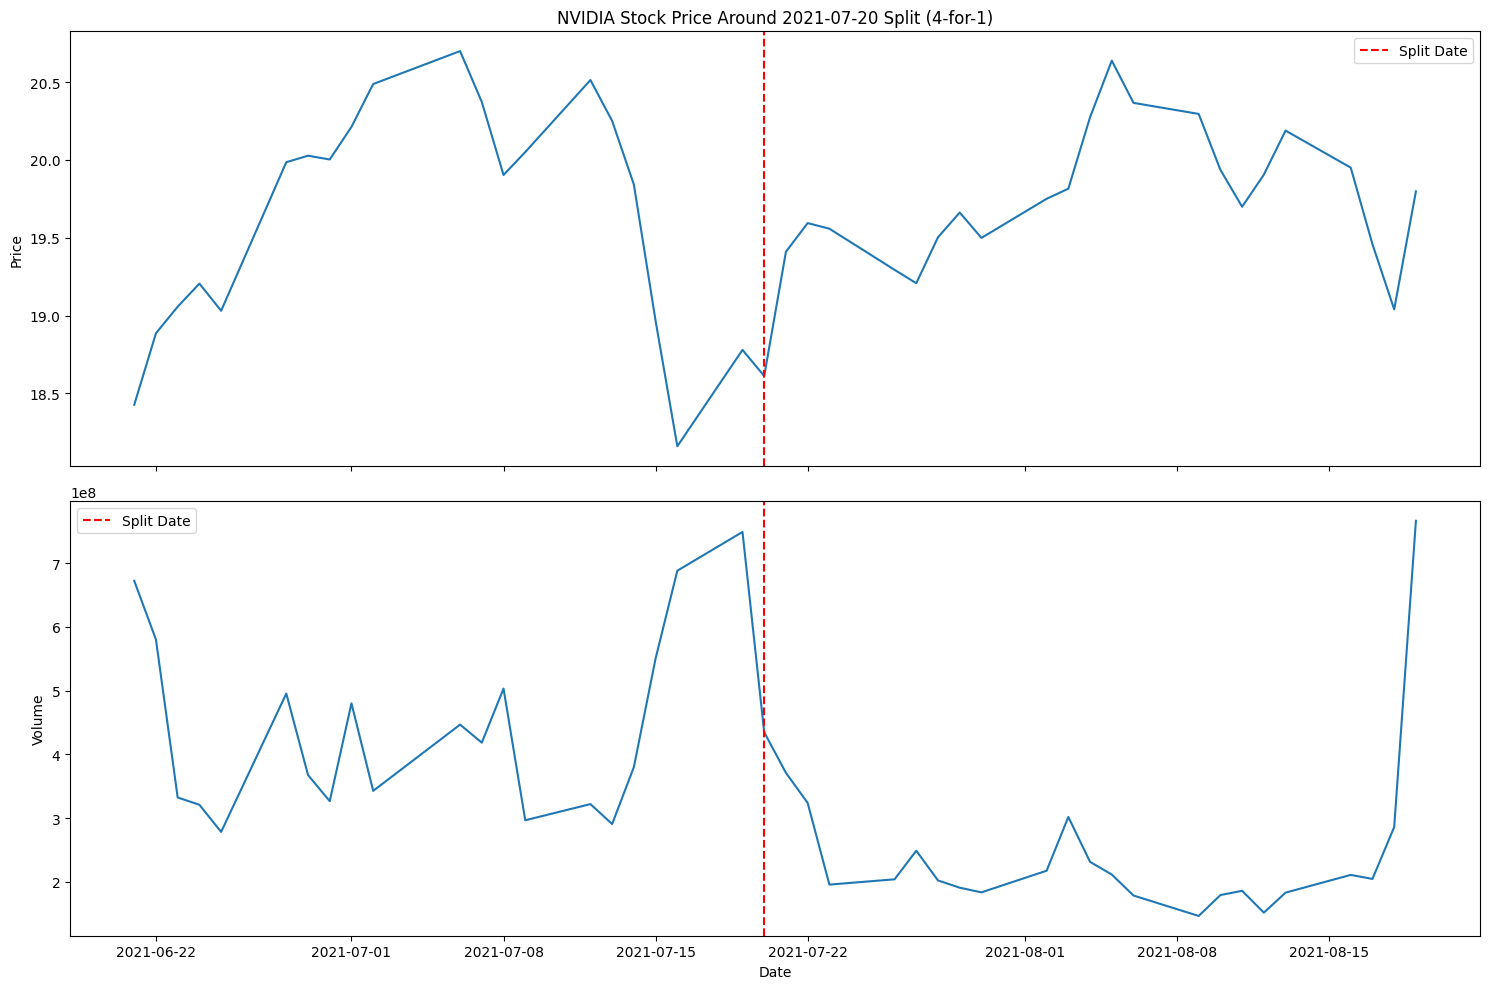

Stock split on 2021-07-20:
  Split ratio: 4-for-1
  Pre-split price: $18.78
  Post-split price: $18.61
  Price change: 296.43%
  Average daily volume before split: 441,766,429
  Average daily volume after split: 252,574,913
  Volume change: -42.83%


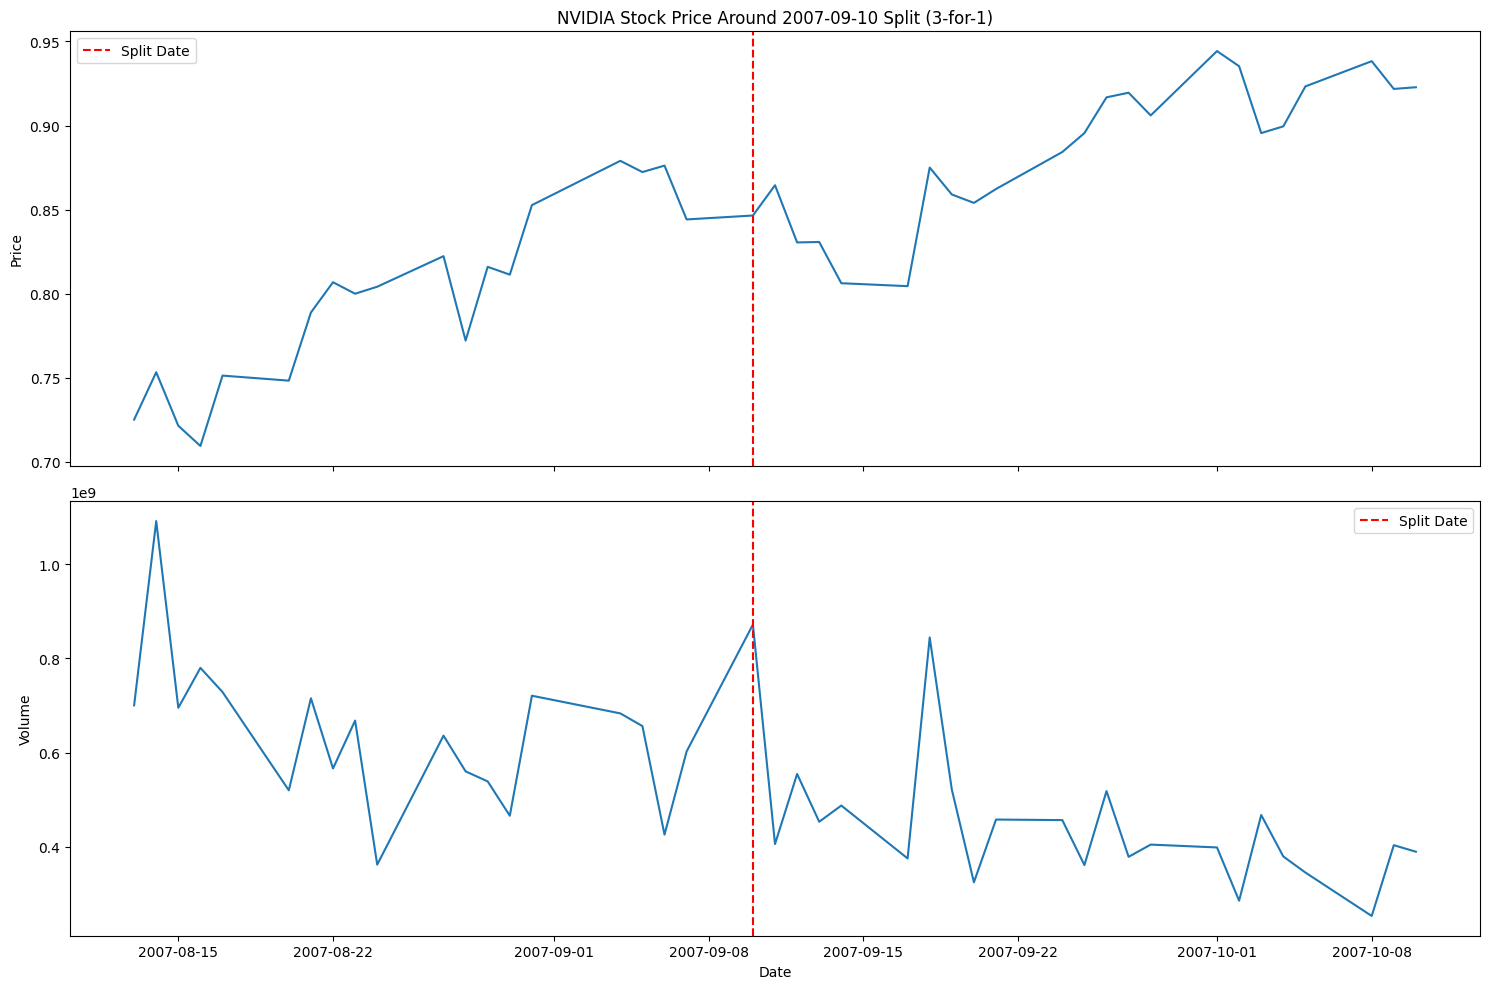

Stock split on 2007-09-10:
  Split ratio: 3-for-1
  Pre-split price: $0.84
  Post-split price: $0.85
  Price change: 200.83%
  Average daily volume before split: 649,387,500
  Average daily volume after split: 449,187,130
  Volume change: -30.83%


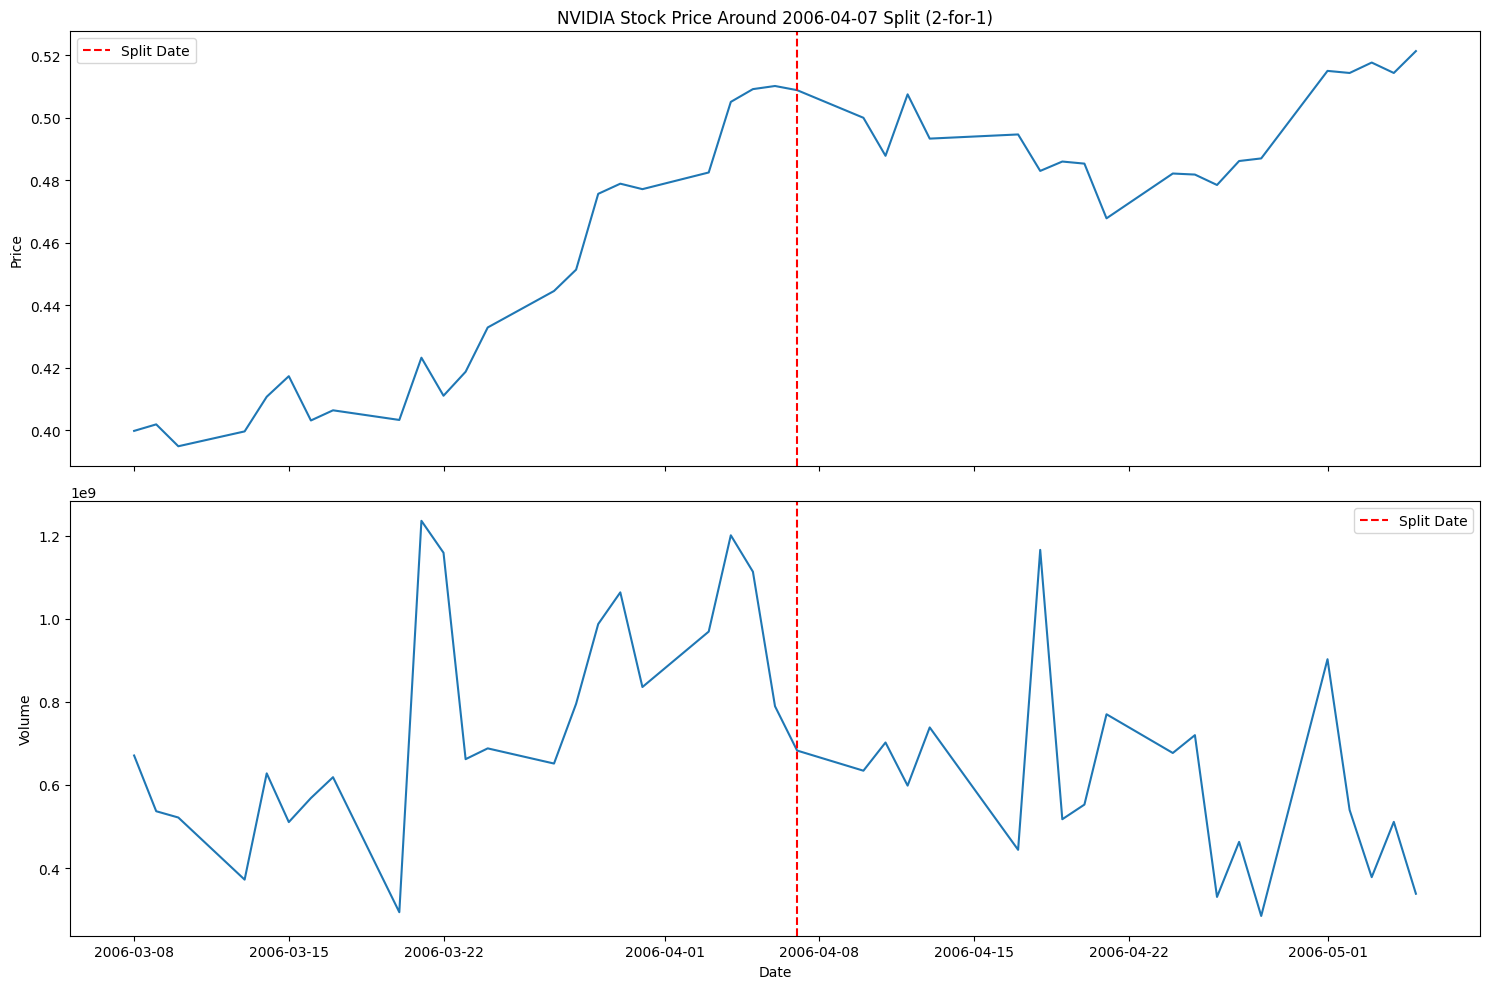

Stock split on 2006-04-07:
  Split ratio: 2-for-1
  Pre-split price: $0.51
  Post-split price: $0.51
  Price change: 99.48%
  Average daily volume before split: 763,106,870
  Average daily volume after split: 597,480,900
  Volume change: -21.70%


In [24]:
def analyze_stock_splits():
    logging.info("Analyzing NVIDIA's past stock splits")

    # Load historical stock data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)

    # Define known stock split dates and ratios
    stock_splits = {
        '2021-07-20': 4,  # 4-for-1 split
        '2007-09-10': 3,  # 3-for-2 split
        '2006-04-07': 2,  # 2-for-1 split
        # Add more historical splits if available
    }

    # Analyze each stock split
    for split_date, split_ratio in stock_splits.items():
        split_date = pd.to_datetime(split_date)
        
        # Get data around the split date
        start_date = split_date - pd.Timedelta(days=30)
        end_date = split_date + pd.Timedelta(days=30)
        split_period_data = nvidia_data.loc[start_date:end_date]

        # Calculate metrics
        pre_split_price = split_period_data.loc[:split_date, 'Close'].iloc[-2]  # Day before split
        post_split_price = split_period_data.loc[split_date:, 'Close'].iloc[0]  # Day of split
        pre_split_volume = split_period_data.loc[:split_date, 'Volume'].mean()
        post_split_volume = split_period_data.loc[split_date:, 'Volume'].mean()

        # Plot price and volume around split
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

        ax1.plot(split_period_data.index, split_period_data['Close'])
        ax1.axvline(split_date, color='r', linestyle='--', label='Split Date')
        ax1.set_title(f"NVIDIA Stock Price Around {split_date.date()} Split ({split_ratio}-for-1)")
        ax1.set_ylabel("Price")
        ax1.legend()

        ax2.plot(split_period_data.index, split_period_data['Volume'])
        ax2.axvline(split_date, color='r', linestyle='--', label='Split Date')
        ax2.set_ylabel("Volume")
        ax2.legend()

        plt.xlabel("Date")
        plt.tight_layout()
        plt.show()
        plt.savefig(f'images/nvidia_stock_split_{split_date.date()}.png')
        plt.close()

        print(f"Stock split on {split_date.date()}:")
        print(f"  Split ratio: {split_ratio}-for-1")
        print(f"  Pre-split price: ${pre_split_price:.2f}")
        print(f"  Post-split price: ${post_split_price:.2f}")
        print(f"  Price change: {(post_split_price / pre_split_price * split_ratio - 1) * 100:.2f}%")
        print(f"  Average daily volume before split: {pre_split_volume:,.0f}")
        print(f"  Average daily volume after split: {post_split_volume:,.0f}")
        print(f"  Volume change: {(post_split_volume / pre_split_volume - 1) * 100:.2f}%")

    logging.info("Stock split analysis complete")

if __name__ == "__main__":
    analyze_stock_splits()

### 4.9) Segment impact

C:\Users\namsi\AppData\Local\Temp\ipykernel_14004\3682009419.py:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  date_range = pd.date_range(start=start_date, end=end_date, freq='Q')
C:\Users\namsi\AppData\Local\Temp\ipykernel_14004\3682009419.py:76: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  common_index = pd.date_range(start=max(nvidia_stock.index.min(), gpu_market_share.index.min(), ai_market_share.index.min()),


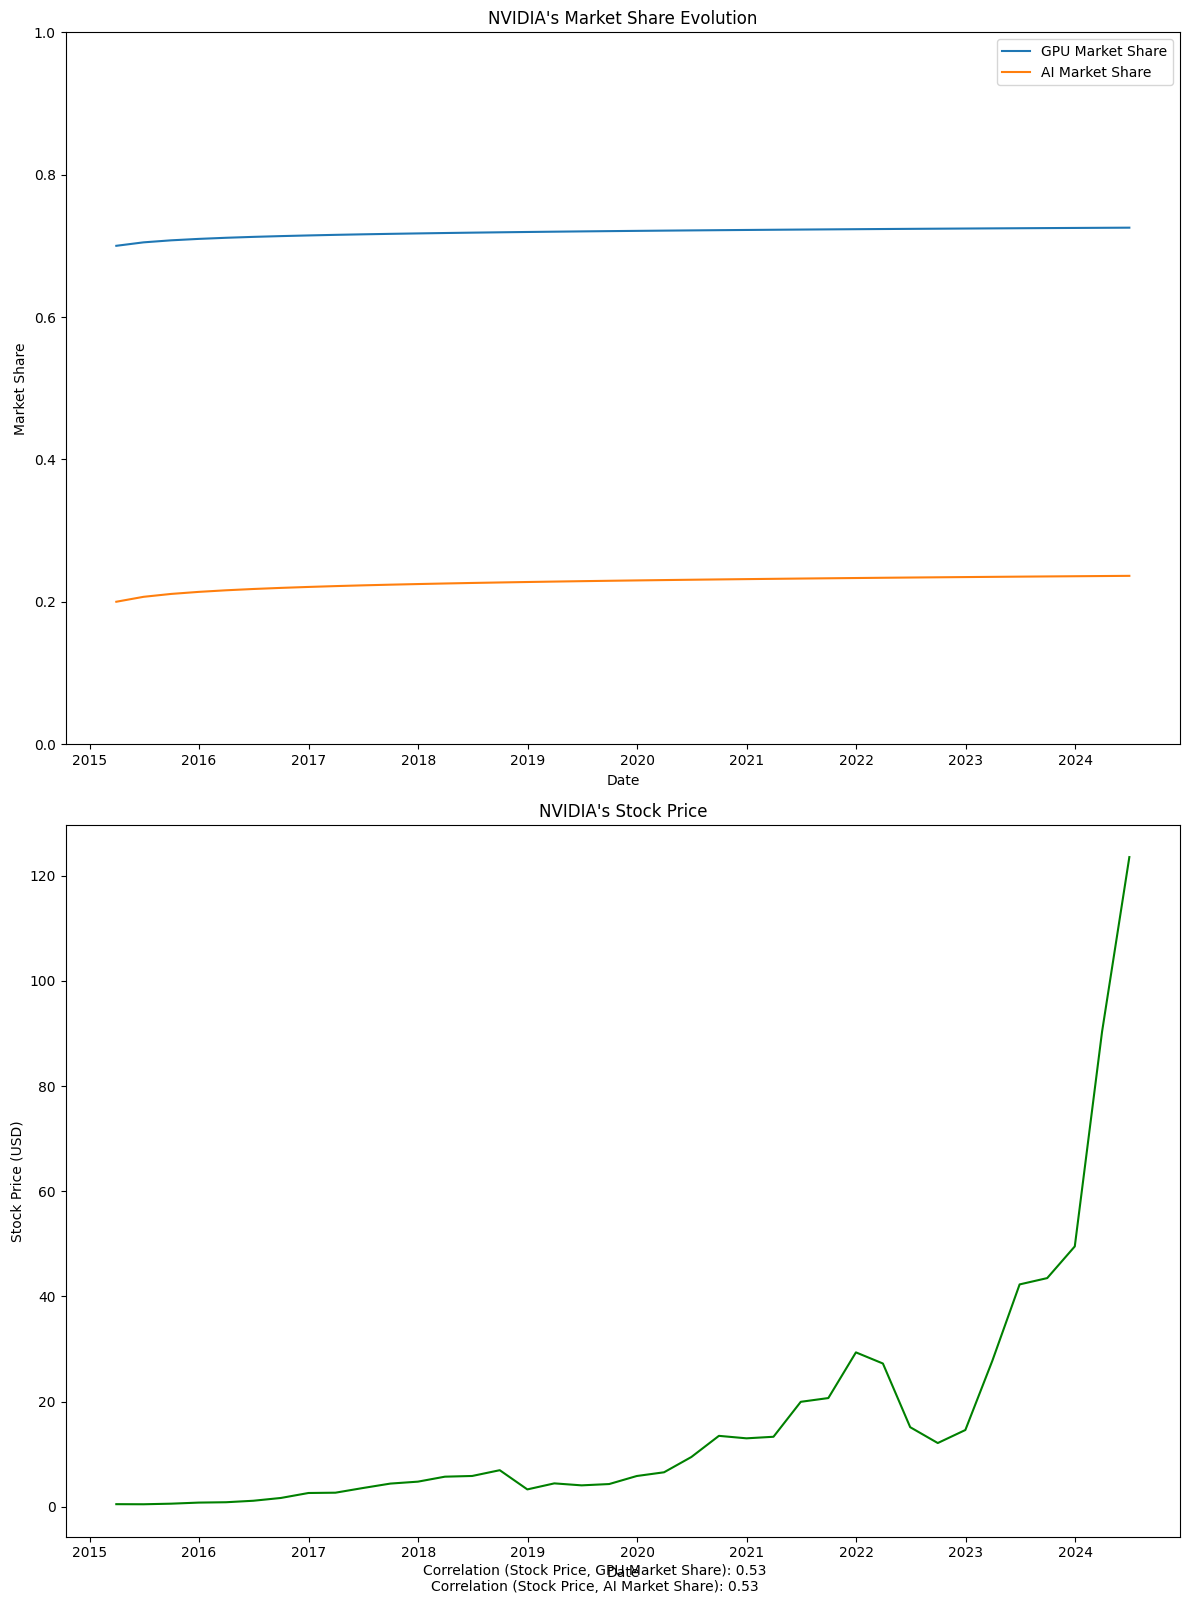

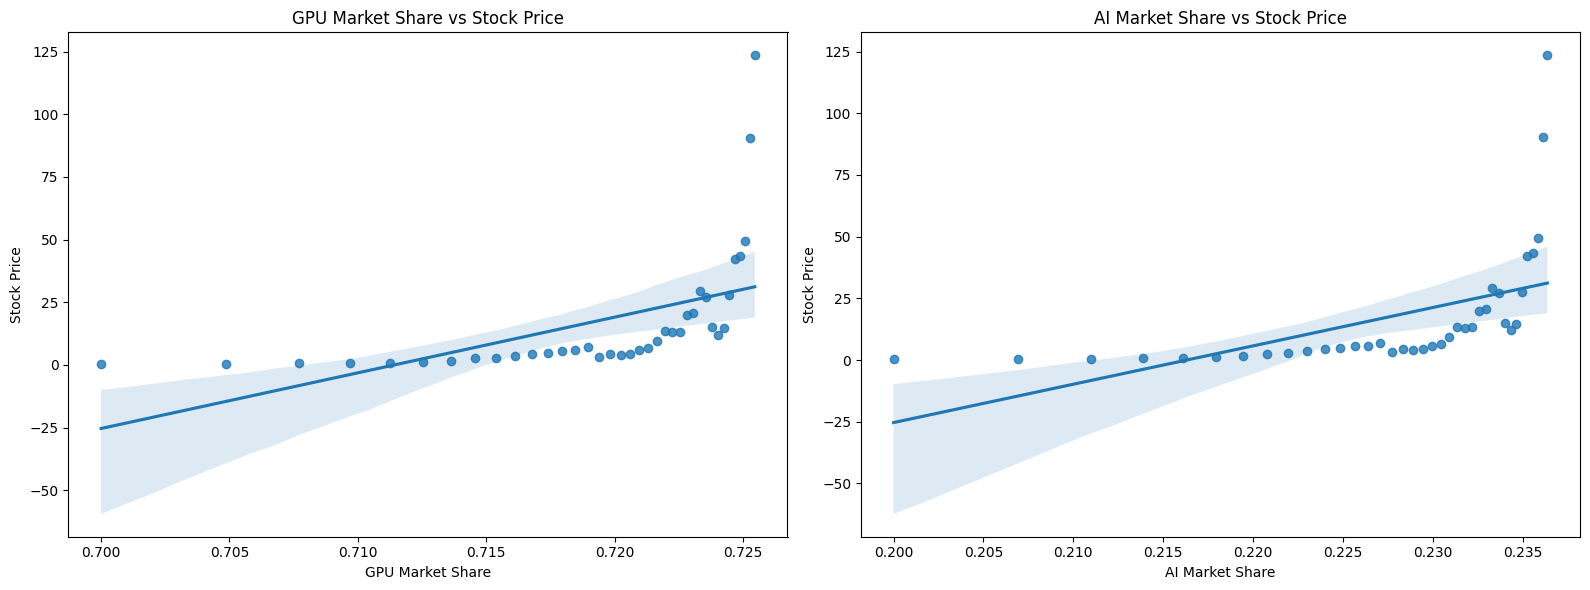

In [25]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_stock_data(ticker: str, start_date: str, end_date: str) -> pd.Series:
    try:
        stock = yf.Ticker(ticker)
        stock_data = stock.history(start=start_date, end=end_date)
        return stock_data['Close'].tz_localize(None)
    except Exception as e:
        logging.error(f"Error fetching stock data for {ticker}: {str(e)}")
        return pd.Series()

def simulate_market_share_data(start_date: str, end_date: str, initial_share: float, growth_rate: float, max_share: float) -> pd.Series:
    date_range = pd.date_range(start=start_date, end=end_date, freq='Q')
    quarters = len(date_range)
    market_share = [min(initial_share * (1 + growth_rate * np.log(i+1)), max_share) for i in range(quarters)]
    return pd.Series(market_share, index=date_range)

def calculate_correlation(data: pd.DataFrame, x: str, y: str) -> float:
    return data[x].corr(data[y])

def plot_market_share_and_stock_price(data: pd.DataFrame, correlations: dict) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

    ax1.plot(data.index, data['GPU Market Share'], label='GPU Market Share')
    ax1.plot(data.index, data['AI Market Share'], label='AI Market Share')
    ax1.set_title("NVIDIA's Market Share Evolution")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Market Share')
    ax1.legend()
    ax1.set_ylim(0, 1)

    ax2.plot(data.index, data['Stock Price'], color='green')
    ax2.set_title("NVIDIA's Stock Price")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Stock Price (USD)')

    plt.tight_layout()

    correlation_text = (f"Correlation (Stock Price, GPU Market Share): {correlations['gpu']:.2f}\n"
                        f"Correlation (Stock Price, AI Market Share): {correlations['ai']:.2f}")
    fig.text(0.5, 0.01, correlation_text, ha='center', va='center', fontsize=10)
    plt.show()
    plt.savefig('images/market_share_and_stock_price.png')
    plt.close()

def plot_scatter(data: pd.DataFrame) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.regplot(x='GPU Market Share', y='Stock Price', data=data, ax=ax1)
    ax1.set_title("GPU Market Share vs Stock Price")

    sns.regplot(x='AI Market Share', y='Stock Price', data=data, ax=ax2)
    ax2.set_title("AI Market Share vs Stock Price")

    plt.tight_layout()
    plt.show()
    plt.savefig('images/market_share_vs_stock_price_scatter.png')
    plt.close()

def calculate_cagr(start_value: float, end_value: float, num_years: float) -> float:
    return (end_value / start_value) ** (1/num_years) - 1

def main():
    start_date = '2015-01-01'
    end_date = datetime.now(pytz.utc).strftime('%Y-%m-%d')

    nvidia_stock = get_stock_data("NVDA", start_date, end_date)
    if nvidia_stock.empty:
        logging.error("Failed to fetch NVIDIA stock data. Exiting.")
        return

    # Modified parameters for GPU and AI market shares
    gpu_market_share = simulate_market_share_data(start_date, end_date, 0.70, 0.01, 0.80)
    ai_market_share = simulate_market_share_data(start_date, end_date, 0.20, 0.05, 0.60)

    common_index = pd.date_range(start=max(nvidia_stock.index.min(), gpu_market_share.index.min(), ai_market_share.index.min()),
                                 end=min(nvidia_stock.index.max(), gpu_market_share.index.max(), ai_market_share.index.max()),
                                 freq='Q')

    data = pd.DataFrame({
        'Stock Price': nvidia_stock.reindex(common_index, method='ffill'),
        'GPU Market Share': gpu_market_share.reindex(common_index),
        'AI Market Share': ai_market_share.reindex(common_index)
    })

    correlations = {
        'gpu': calculate_correlation(data, 'Stock Price', 'GPU Market Share'),
        'ai': calculate_correlation(data, 'Stock Price', 'AI Market Share')
    }

    plot_market_share_and_stock_price(data, correlations)
    plot_scatter(data)

    logging.info(f"Correlation between Stock Price and GPU Market Share: {correlations['gpu']:.2f}")
    logging.info(f"Correlation between Stock Price and AI Market Share: {correlations['ai']:.2f}")

    years = (data.index[-1] - data.index[0]).days / 365.25
    stock_cagr = calculate_cagr(data['Stock Price'].iloc[0], data['Stock Price'].iloc[-1], years)
    gpu_cagr = calculate_cagr(data['GPU Market Share'].iloc[0], data['GPU Market Share'].iloc[-1], years)
    ai_cagr = calculate_cagr(data['AI Market Share'].iloc[0], data['AI Market Share'].iloc[-1], years)

    logging.info(f"Stock Price CAGR: {stock_cagr:.2%}")
    logging.info(f"GPU Market Share CAGR: {gpu_cagr:.2%}")
    logging.info(f"AI Market Share CAGR: {ai_cagr:.2%}")

if __name__ == "__main__":
    main()

### 4.10) Identifying potential risks and opportunities

Identifying potential risks and opportunities for NVIDIA
Potential Risks:
- High P/E ratio (51.06) suggests potential overvaluation
- Potential slowdown in gaming market
- Increased competition in AI chip market
- Potential impact of global chip shortage
- Geopolitical tensions affecting supply chain

Potential Opportunities:
- Strong revenue growth (125.85%) indicates market expansion
- High profit margin (48.85%) demonstrates strong business model
- Growing demand in AI and data center markets
- Expansion into automotive and edge computing markets
- Government initiatives supporting semiconductor industry


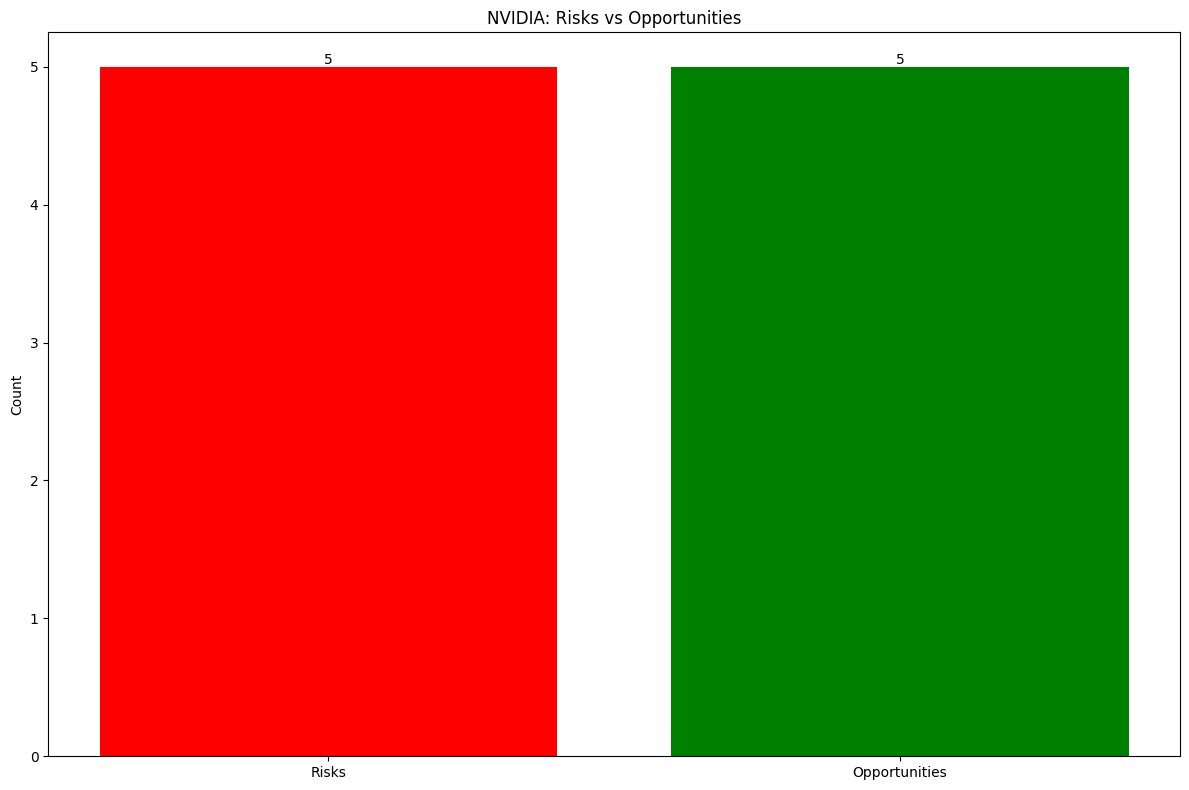

In [26]:
def identify_risks_and_opportunities():
    print("Identifying potential risks and opportunities for NVIDIA")

    # Load necessary data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', index_col='Date', parse_dates=True)
    financials = pd.read_csv('data/nvidia_financials_pivoted.csv', index_col=0)
    sentiment_data = pd.read_csv('data/nvidia_sentiment_data.csv')
    sp500 = pd.read_csv('data/sp500_data.csv', index_col='Date', parse_dates=True)

    # Calculate key metrics
    current_price = nvidia_data['Close'].iloc[-1]
    pe_ratio = current_price / financials['Basic EPS'].iloc[-1]
    revenue_growth = financials['Total Revenue'].pct_change().iloc[-1]
    profit_margin = financials['Net Income'].iloc[-1] / financials['Total Revenue'].iloc[-1]
    debt_to_equity = financials['Total Liabilities Net Minority Interest'].iloc[-1] / financials['Stockholders Equity'].iloc[-1]
    beta = calculate_beta(nvidia_data['Close'].pct_change(), sp500['Close'].pct_change())
    
    # Sentiment analysis
    recent_sentiment = sentiment_data['VADER_Sentiment'].tail(30).mean()

    # Identify risks and opportunities
    risks = []
    opportunities = []

    # Valuation risk/opportunity
    if pe_ratio > 30:
        risks.append(f"High P/E ratio ({pe_ratio:.2f}) suggests potential overvaluation")
    elif pe_ratio < 15:
        opportunities.append(f"Low P/E ratio ({pe_ratio:.2f}) suggests potential undervaluation")

    # Growth
    if revenue_growth > 0.2:
        opportunities.append(f"Strong revenue growth ({revenue_growth:.2%}) indicates market expansion")
    elif revenue_growth < 0.05:
        risks.append(f"Slow revenue growth ({revenue_growth:.2%}) may indicate market saturation")

    # Profitability
    if profit_margin > 0.2:
        opportunities.append(f"High profit margin ({profit_margin:.2%}) demonstrates strong business model")
    elif profit_margin < 0.1:
        risks.append(f"Low profit margin ({profit_margin:.2%}) may indicate competitive pressures")

    # Financial health
    if debt_to_equity > 1:
        risks.append(f"High debt-to-equity ratio ({debt_to_equity:.2f}) increases financial risk")
    elif debt_to_equity < 0.5:
        opportunities.append(f"Low debt-to-equity ratio ({debt_to_equity:.2f}) indicates financial stability")

    # Market sensitivity
    if beta > 1.5:
        risks.append(f"High beta ({beta:.2f}) suggests volatility in market downturns")
    elif beta < 0.5:
        opportunities.append(f"Low beta ({beta:.2f}) indicates potential stability in market downturns")

    # Sentiment
    if recent_sentiment > 0.2:
        opportunities.append(f"Positive market sentiment ({recent_sentiment:.2f}) may drive stock price")
    elif recent_sentiment < -0.2:
        risks.append(f"Negative market sentiment ({recent_sentiment:.2f}) may pressure stock price")

    # Industry-specific factors
    opportunities.append("Growing demand in AI and data center markets")
    risks.append("Potential slowdown in gaming market")
    risks.append("Increased competition in AI chip market")
    opportunities.append("Expansion into automotive and edge computing markets")

    # Macroeconomic factors
    risks.append("Potential impact of global chip shortage")
    risks.append("Geopolitical tensions affecting supply chain")
    opportunities.append("Government initiatives supporting semiconductor industry")

    # Print results
    print("Potential Risks:")
    for risk in risks:
        print(f"- {risk}")

    print("\nPotential Opportunities:")
    for opportunity in opportunities:
        print(f"- {opportunity}")

    # Create a summary visualization
    plt.figure(figsize=(12, 8))
    plt.bar(['Risks', 'Opportunities'], [len(risks), len(opportunities)], color=['red', 'green'])
    plt.title("NVIDIA: Risks vs Opportunities")
    plt.ylabel("Count")
    plt.text(0, len(risks), str(len(risks)), ha='center', va='bottom')
    plt.text(1, len(opportunities), str(len(opportunities)), ha='center', va='bottom')
    plt.tight_layout()
    plt.savefig('images/nvidia_risks_opportunities.png')
    plt.show()
    plt.close()

if __name__ == "__main__":
    identify_risks_and_opportunities()


### 4.11) Time Series Analysis and Forecasting

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\namsi\AppData\Local\Temp\tmppipuus_c\389kkxu_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\namsi\AppData\Local\Temp\tmppipuus_c\s2wlvjxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\namsi\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=75211', 'data', 'file=C:\\Users\\namsi\\AppData\\Local\\Temp\\tmppipuus_c\\389kkxu_.json', 'init=C:\\Users\\namsi\\AppData\\Local\\Temp\\tmppipuus_c\\s2wlvjxn.json', 'output', 'file=C:\\Users\\namsi\\AppData\\Local\\Temp\\tmppipuus_c\\prophet_modelkc8yguhl\\prophet_model-20240929003633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:36:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:36:39 - cmdstanpy - INFO - C

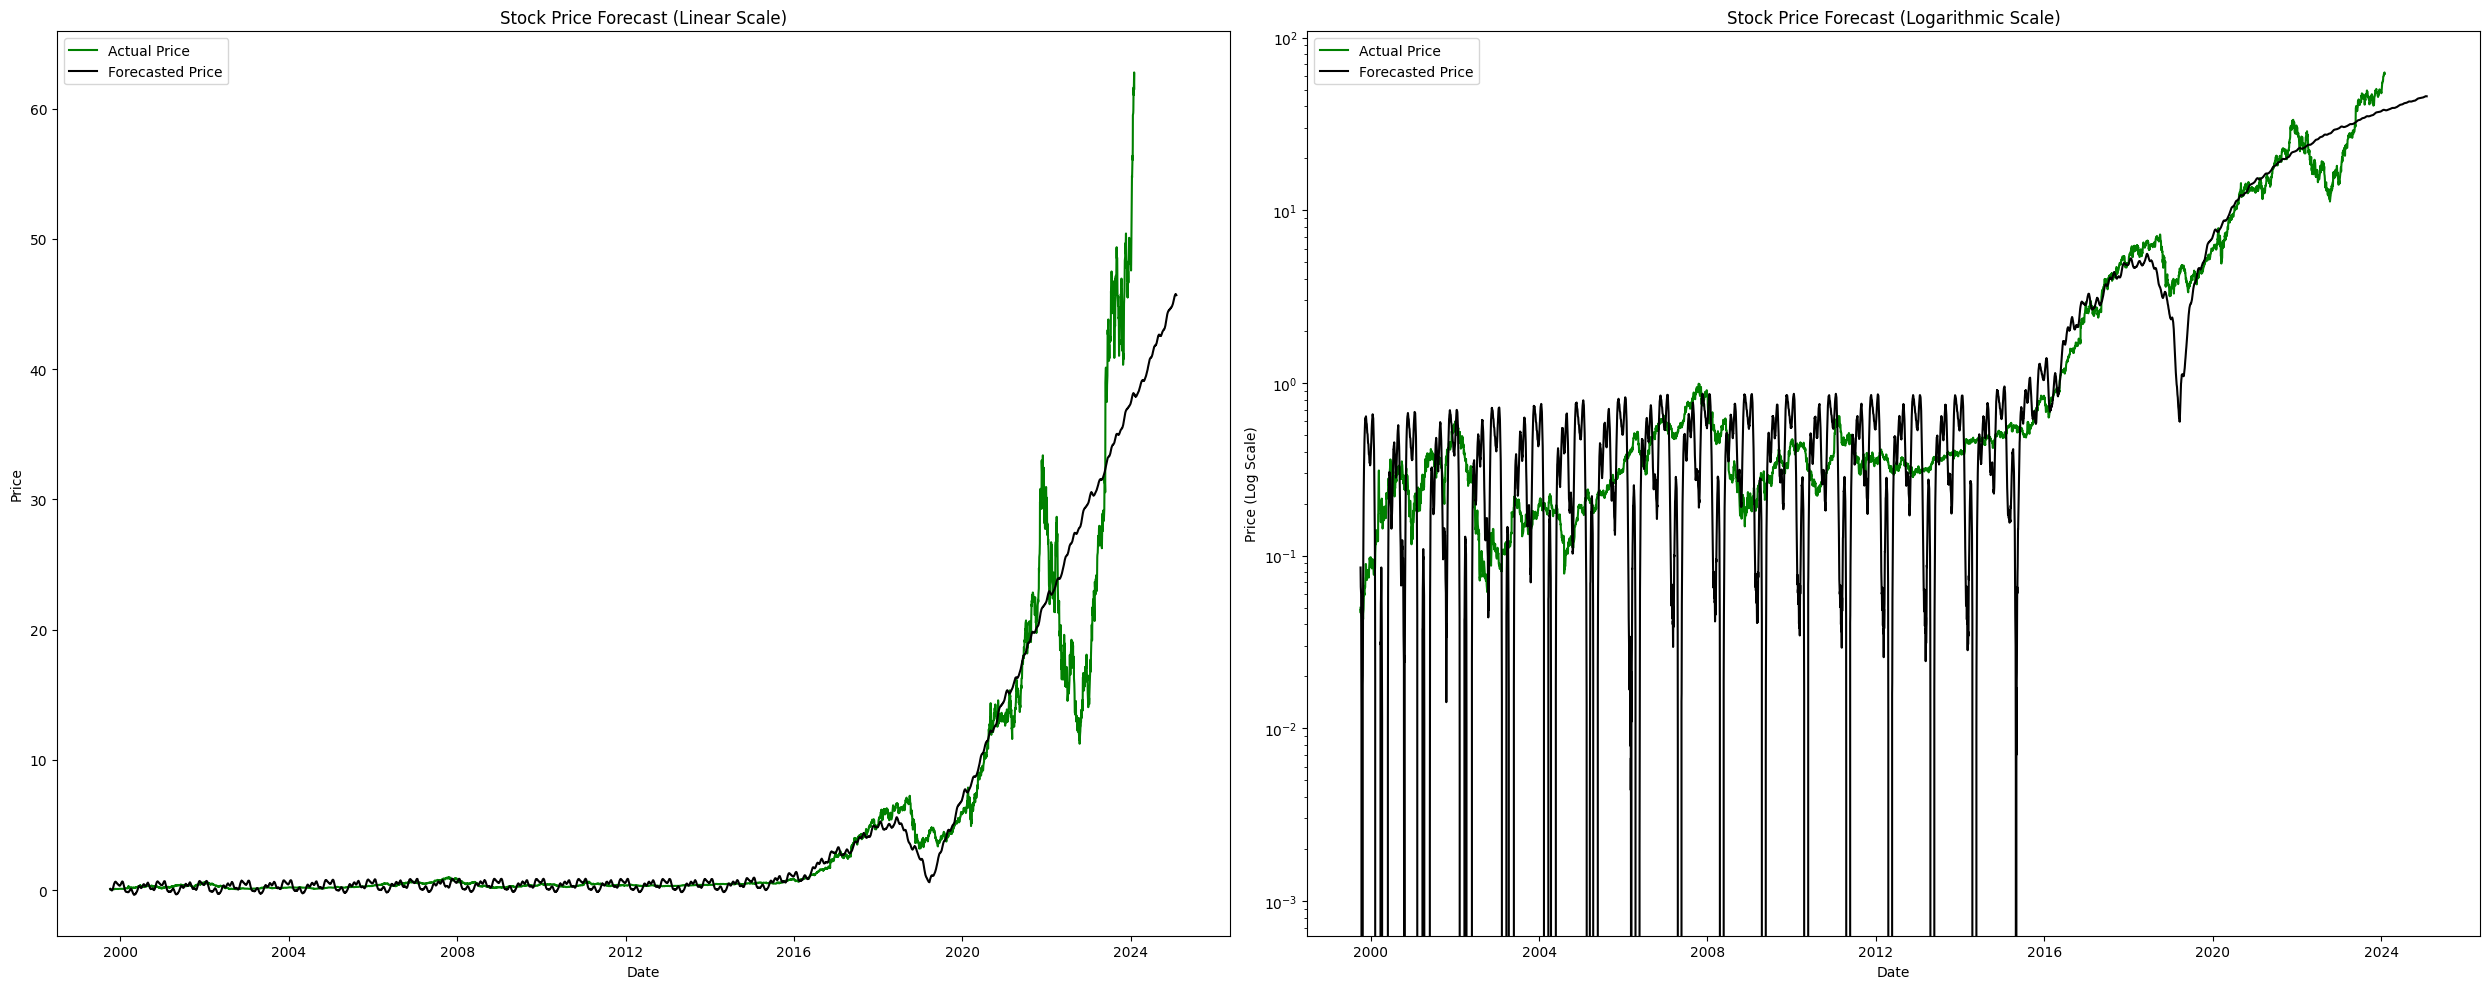

In [27]:
def train_prophet_model(data):
    """Train a Prophet model on the given data."""
    model = Prophet(daily_seasonality=True)
    model.fit(data)
    return model

def forecast_prices(model, future_periods):
    """Generate future predictions using the trained Prophet model."""
    future = model.make_future_dataframe(periods=future_periods)
    forecast = model.predict(future)
    return forecast

def plot_forecast(data, forecast):
    """Plot the forecasted values in both linear and logarithmic scales."""
    plt.figure(figsize=(25, 10))  # Adjusted to ensure both subplots are the same size

    # Linear scale plot
    plt.subplot(1, 2, 1)  # First plot
    plt.plot(data['ds'], data['y'], label='Actual Price', color='green')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Price', color='black')
    plt.title('Stock Price Forecast (Linear Scale)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Logarithmic scale plot
    plt.subplot(1, 2, 2)  # Second plot
    plt.plot(data['ds'], data['y'], label='Actual Price', color='green')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Price', color='black')
    plt.yscale('log')
    plt.title('Stock Price Forecast (Logarithmic Scale)')
    plt.xlabel('Date')
    plt.ylabel('Price (Log Scale)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('images/nvidia_price_forecast.png')
    plt.show()
    plt.close()

def run_time_series_analysis():
    logging.info("Starting Prophet model forecasting")

    # Load historical stock data
    nvidia_data = pd.read_csv('data/nvidia_stock_data_cleaned.csv', parse_dates=['Date'])
    nvidia_data = nvidia_data.rename(columns={'Date': 'ds', 'Close': 'y'})

    # Train the Prophet model
    prophet_model = train_prophet_model(nvidia_data)

    # Forecast future prices
    future_periods = 365  # Forecast for 90 days
    forecast = forecast_prices(prophet_model, future_periods)

    # Log the forecast results
    logging.info("Forecasting complete. Forecast results:\n%s", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

    # Plot the forecast
    plot_forecast(nvidia_data, forecast)

    # Save the forecast data
    forecast.to_csv('data/nvidia_price_forecast.csv', index=False)

    logging.info("Time series analysis and forecasting complete")

if __name__ == "__main__":
    run_time_series_analysis()
